# Определение стоимости автомобилей

**Описание задачм:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Описание набора данных**

Независимые признаки:
- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.

Целевой признак
- Price — цена (евро)

**Цель работы** — разработать модели машинного обучения, способные предсказывать стоимость автоомобиля, и отобрать из них лучшую на основе метрик качества и скорости обучения.

**Примечания:**
- Для оценки качества моделей будет использована метрика RMSE;
- Значение метрики RMSE должно быть меньше 2500.

**Работа будет проводиться в следующие 5 этапов:**
1. Исследовательский анализ и предобработка данных;
2. Формирование и анализ датасета;
3. Формирование выборок и их препроцессинг;
4. Обучение моделей;
5. Анализ качества и быстродействия моделей;
6. Выводы.

# Библиотеки

In [1]:
import os

import warnings

import time

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression

# Константы и настройки

In [2]:
DATA_PATH1 = 'autos.csv'
DATA_PATH2 = '/datasets/autos.csv'

RANDOM_STATE = 42
TEST_SIZE = 0.2

SCALER = MinMaxScaler()
OHE = OneHotEncoder(drop='first')
OE = OrdinalEncoder()


sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Функции

## Работа с данными

In [ ]:
def analyze_dataframe(df, asc=False):
    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())  # asc

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nulls_num': df.isna().sum(),
            'completeness': 100 - (df.isna().sum() / (df.isna().sum() + 
                                                      df.notna().sum()) * 100),
            'uniques_num': df.nunique(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )

    memory = df.memory_usage(index=False).sum() / 1_000_000

    print('General data analysis:')
    print()
    print('Shape of the table:     ', df.shape)
    print(f'Duplicates in the table: {df.duplicated().sum()}, ({round(df.duplicated().sum() / df.shape[0], 4) * 100}%)')
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()
    return table_scan

In [ ]:
price_qs = []
def get_ten_qbins(price):
    if price <= price_qs[0]:
        return '0-10'
    elif price <= price_qs[1]:
        return '10-20'
    elif price <= price_qs[2]:
        return '20-30'
    elif price <= price_qs[3]:
        return '30-40'
    elif price <= price_qs[4]:
        return '40-50'
    elif price <= price_qs[5]:
        return '50-60'
    elif price <= price_qs[6]:
        return '60-70'
    elif price <= price_qs[7]:
        return '70-80'
    elif price <= price_qs[8]:
        return '80-90'
    else:
        return '90-100'

In [ ]:
def get_postal_bins(code):
    if code < 10000:
        return '0-10k'
    elif code < 20000:
        return '10-20k'
    elif code < 30000:
        return '20-30k'
    elif code < 40000:
        return '30-40k'
    elif code < 50000:
        return '40-50k'
    elif code < 60000:
        return '50-60k'
    elif code < 70000:
        return '60-70k'
    elif code < 80000:
        return '70-80k'
    elif code < 90000:
        return '80-90k'
    else:
        return '90-100k'

In [ ]:
models_0_10 = None
models_10_20 = None
models_20_30 = None
models_30_40 = None
models_40_50 = None
models_50_60 = None
models_60_70 = None
models_70_80 = None
models_80_90 = None
models_90_100 = None
def get_models_bins(model):
    if model in models_0_10:
        return '0-10'
    elif model in models_10_20:
        return '10-20'
    elif model in models_20_30:
        return '20-30'
    elif model in models_30_40:
        return '30-40'
    elif model in models_40_50:
        return '40-50'
    elif model in models_50_60:
        return '50-60'
    elif model in models_60_70:
        return '60-70'
    elif model in models_70_80:
        return '70-80'
    elif model in models_80_90:
        return '80-90'
    elif model in models_90_100:
        return '90-100'

In [3]:
brands_0_10 = None
brands_10_20 = None
brands_20_30 = None
brands_30_40 = None
brands_40_50 = None
brands_50_60 = None
brands_60_70 = None
brands_70_80 = None
brands_80_90 = None
brands_90_100 = None
def get_brand_bins(brand):
    if brand in brands_0_10:
        return '0-10'
    elif brand in brands_10_20:
        return '10-20'
    elif brand in brands_20_30:
        return '20-30'
    elif brand in brands_30_40:
        return '30-40'
    elif brand in brands_40_50:
        return '40-50'
    elif brand in brands_50_60:
        return '50-60'
    elif brand in brands_60_70:
        return '60-70'
    elif brand in brands_70_80:
        return '70-80'
    elif brand in brands_80_90:
        return '80-90'
    elif brand in brands_90_100:
        return '90-100'

## Визуализация

In [4]:
def create_visualization(data, dtype, target, figsize=None, bins=50):
    if dtype == 'numbers':
        target_nunique = data[target].nunique()

        print('Visualization of quantitative features distribution:')
        print()

        if target_nunique <= 10:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.25, .75)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, y=target, orient='h',
                                ax=ax_box).set_title(i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, hue=target, kde=True, 
                                 bins=bins)

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
        else:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.25, .75)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, ax=ax_box).set_title(
                        i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, kde=True, bins=bins)

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
    elif dtype == 'categories':
        print('Visualization of categorical features and target prevalence:')
        print()

        for i in data.drop(target, axis=1):
            if data[i].dtype == 'O' or data[i].unique().shape[0] <= 10:
                bar_data = data[i].value_counts().reset_index().rename(
                    columns={'index': data[i].name, data[i].name: 'Count'}
                    ).sort_values(by=i)

                if data[target].shape[0] < 10:
                    prev_data = (data.groupby([i])[target]
                                 .value_counts(normalize=True)
                                 .reset_index(name='prevalance'))
                    prev_data['prevalance'] = (
                        prev_data['prevalance'].round(4) * 100)
                else:
                    prev_data = (data.groupby([i])[target]
                                 .mean()
                                 .reset_index(name='target_mean'))
                    prev_data['target_mean'] = prev_data['target_mean'].round(2)

                print(f'Feature: {i}')

                figure, (ax_bar, ax_prev) = plt.subplots(
                    1, 2, figsize=(18, 5) if figsize is None else figsize)

                sns.barplot(data=bar_data, x=i, y='Count',
                            linewidth=0.5, ax=ax_bar,
                            color='#CC8963', alpha=0.8).set_title(
                                f'{i} distribution', y=1.02, fontsize=14)
                if data[target].shape[0] < 10:
                    try:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, linewidth=0.5,
                                    palette={0: '#008744', 1: '#d62d20'},
                                    ax=ax_prev, alpha=0.8).set_title(
                                        f'target prevalence, %', y=1.02,
                                        fontsize=14)
                    except:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, ax=ax_prev, alpha=0.8
                                    ).set_title(f'target prevalence, %', y=1.02,
                                                fontsize=14)
                else:
                    sns.barplot(data=prev_data, x=i, y='target_mean',
                                color='#008744', alpha=0.8).set_title(
                                    f'target means', y=1.02, fontsize=14)

                r_ = 0 if bar_data.shape[0] < 5 else 90
                ax_bar.tick_params(axis='x', rotation=r_)
                ax_prev.tick_params(axis='x', rotation=r_)

                plt.show()
                print()
    elif dtype == 'target':
        print('Visualization of target distribution:')
        print()
        print(f'Target: {target}')

        if data[target].unique().shape[0] <= 10:
            plt.figure(figsize=(5, 5) if figsize is None else figsize)

            target_ = data[target].value_counts().reset_index().rename(
                columns={'index': data[target].name,
                         data[target].name: 'Count'})

            sns.barplot(
                data=target_,
                x=target, y='Count'
            ).set_title(target, y=1.02, fontsize=14)

            plt.show()
            print()
            print('Target statistics:')
            display(pd.DataFrame(data[target].describe()))
        else:
            print('Visualization of target distribution:')
            print()
            print(f'Target: {target}')

            figure, (ax_box, ax_hist) = plt.subplots(
                2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                figsize=(9, 7) if figsize is None else figsize)

            sns.despine(fig=None, ax=None, top=True, right=True, left=False,
                        bottom=False, offset=None, trim=False)

            sns.boxplot(data=data, x=target, ax=ax_box).set_title(target, y=1.5,
                                                                  fontsize=14)
            sns.histplot(data=data, x=target, kde=True, bins=bins)

            plt.show()
            print()
            print('Feature statistics:')
            display(pd.DataFrame(data[target].describe()))

    print()

In [ ]:
def get_corr_map(df, method='pearson', figisze=(15, 12)):
    plt.figure(figsize=figisze)

    sns.heatmap(
        round(df.corr(method=method), 2), vmax=1, vmin=-1, square=True,
        linewidths=3, annot=True, cmap='coolwarm'
    )

    plt.show()


def sort_price(data, index, values):
    models_ = (data
           .pivot_table(index=index, values=values,
                        aggfunc={values[0]: np.count_nonzero,
                                 values[1]: np.mean})
           .sort_values(values[1], ascending=True)
           .reset_index().reset_index()
           .rename(columns={'index': 'number', values[0]: 'count'}))

    ax = models_.plot(x='number', y=values[1], grid=False, legend=False,
                      color='#008744', figsize=(25, 7))
    ax2 = ax.twinx()
    models_.plot(kind='bar', x='number', y='count', grid=True, ax=ax2,
                 legend=False, color='#d62d20')

    ax.tick_params(axis='x', rotation=90)
    ax.figure.legend()

    plt.show()

    return models_

## ML & metrics

In [5]:
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))

    return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)


def get_prediction(X_train, y_train, X_val, y_val,
                   model, model_type, print_res):
    model = model
    
    start = time.time()
    
    if model_type == 'CatBoost':
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True,
                  verbose=False)
    elif model_type == 'LGBM':
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=False, early_stopping_rounds=100)
        
        import lightgbm as lgb
        lgb.plot_metric(model)
    elif model_type == 'XGB':
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=False, early_stopping_rounds=100)
        
        results = model.evals_result()
        plt.plot(results['validation_0']['rmse'], label='train')
        plt.plot(results['validation_1']['rmse'], label='test')
        plt.legend()
        plt.show()
    elif model_type == 'RF' or model_type == 'MLP':
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
    
    end = time.time()
    study_time = exec_time(start, end)
    
    zeros_correction = np.vectorize(lambda x: 0 if x < 0 else x)
    preds_correction = np.vectorize(lambda x: round(abs(x)))

    train_preds = preds_correction(zeros_correction(model.predict(X_train)))
    
    start = time.time()
    
    val_preds = preds_correction(zeros_correction(model.predict(X_val)))
    
    end = time.time()
    pred_time = exec_time(start, end)
    
    
    metrics = {
        'train_rmse': round(mean_squared_error(train_preds, y_train) ** 0.5, 2),
        'train_r2': r2_score(train_preds, y_train),
        'val_rmse': round(mean_squared_error(val_preds, y_val) ** 0.5, 2),
        'val_r2': r2_score(val_preds, y_val)
    }

    if print_res:
        print('Training RMSE score:   ', metrics['train_rmse'])
        print('Training R2 score:     ', metrics['train_r2'])
        print()
        print('Validation RMSE score: ', metrics['val_rmse'])
        print('Validation R2 score:   ', metrics['val_r2'])

    return metrics, study_time, pred_time

# Исследовательский анализ и первичная обработка данных

## Загрузка данных

In [6]:
if os.path.exists(DATA_PATH1):
    data = pd.read_csv(DATA_PATH1)
elif os.path.exists(DATA_PATH2):
    data = pd.read_csv(DATA_PATH2)
else:
    print("Path doesn't exist!")

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Верхнеуровневый анализ данных и первичная предобработка

### Верхнеуровневый анализ

In [7]:
analyze_dataframe(data)

General data analysis:

Shape of the table:      (354369, 16)
Duplicates in the table: 4, (0.0%)
Memory usage:            45.4+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
DateCrawled,354369,0,100.000000,271174,"[2016-04-07 14:36:58, 2016-04-07 14:36:56, 201...",object
Price,354369,0,100.000000,3731,"[20000, 19999, 19998, 19997, 19995, 19990, 199...",int64
VehicleType,316879,37490,89.420632,8,"[wagon, suv, small, sedan, other, coupe, conve...",object
RegistrationYear,354369,0,100.000000,151,"[9999, 9996, 9450, 9229, 9000, 8888, 8500, 845...",int64
Gearbox,334536,19833,94.403291,2,"[manual, auto, nan]",object
Power,354369,0,100.000000,712,"[20000, 19312, 19211, 19208, 17932, 17700, 174...",int64
Model,334664,19705,94.439412,250,"[zafira, z_reihe, ypsilon, yeti, yaris, xc_rei...",object
Kilometer,354369,0,100.000000,13,"[150000, 125000, 100000, 90000, 80000, 70000, ...",int64
RegistrationMonth,354369,0,100.000000,13,"[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",int64
FuelType,321474,32895,90.717303,7,"[petrol, other, lpg, hybrid, gasoline, electri...",object


При первичном ознакомлении и высокоуровневом анализе данных можно выделить следующие моменты, требующие обработки:

1. В данных присутствует 4 явных дубликата;
2. Имена полей пишутся с использованием разных CamelCase, что может затруднять дальнейшую работу.
3. Используемые типы данных требуют чрезмерного объема памяти для своих значений.

Решим данные моменты.

### Изменение типов данных и оптимизация использования памяти

In [8]:
memory_before = data.memory_usage(index=False).sum()
print(f'Initial value of memory usage:                 ', memory_before)

data['DateCrawled'] = pd.to_datetime(data['DateCrawled']).dt.date
data['DateCreated'] = pd.to_datetime(data['DateCreated']).dt.date
data['LastSeen'] = pd.to_datetime(data['LastSeen']).dt.date

data = data.astype(
    {
        'Price':                'int16',
        'RegistrationYear':     'int16',
        'Power':                'int16',
        'Kilometer':            'int32',
        'RegistrationMonth':    'int8',
        'NumberOfPictures':     'int8',
        'PostalCode':           'int32',
    }
)

memory_after = data.memory_usage(index=False).sum()
memory_percent = round((memory_before - memory_after) / memory_before * 100, 2)

print('Value of memory usage after changing data types:', memory_after)
print()
print(f'Memory usage reduced by {memory_percent}%', '\n')

analyze_dataframe(data)

Initial value of memory usage:                  45359232
Value of memory usage after changing data types: 31184472

Memory usage reduced by 31.25% 

General data analysis:

Shape of the table:      (354369, 16)
Duplicates in the table: 6828, (1.9300000000000002%)
Memory usage:            31.2+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
DateCrawled,354369,0,100.000000,34,"[2016-04-07, 2016-04-06, 2016-04-05, 2016-04-0...",object
Price,354369,0,100.000000,3731,"[20000, 19999, 19998, 19997, 19995, 19990, 199...",int16
VehicleType,316879,37490,89.420632,8,"[wagon, suv, small, sedan, other, coupe, conve...",object
RegistrationYear,354369,0,100.000000,151,"[9999, 9996, 9450, 9229, 9000, 8888, 8500, 845...",int16
Gearbox,334536,19833,94.403291,2,"[manual, auto, nan]",object
Power,354369,0,100.000000,712,"[20000, 19312, 19211, 19208, 17932, 17700, 174...",int16
Model,334664,19705,94.439412,250,"[zafira, z_reihe, ypsilon, yeti, yaris, xc_rei...",object
Kilometer,354369,0,100.000000,13,"[150000, 125000, 100000, 90000, 80000, 70000, ...",int32
RegistrationMonth,354369,0,100.000000,13,"[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",int8
FuelType,321474,32895,90.717303,7,"[petrol, other, lpg, hybrid, gasoline, electri...",object


### Приведение названий полей к единому стилю

In [9]:
data = data.rename(
    columns={
        'DateCrawled':          'date_crawled',
        'Price':                'price',
        'VehicleType':          'vehicle_type',
        'RegistrationYear':     'registration_year',
        'Gearbox':              'gearbox',
        'Power':                'power',
        'Model':                'model',
        'Kilometer':            'kilometer',
        'RegistrationMonth':    'registration_month',
        'FuelType':             'fuel_type',
        'Brand':                'brand',
        'Repaired':             'repaired',
        'DateCreated':          'date_created',
        'NumberOfPictures':     'number_of_pictures',
        'PostalCode':           'postal_code',
        'LastSeen':             'last_seen'
    }
)

print('Сolumn names after processing:')
data.columns

Сolumn names after processing:


Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Теперь данные готовы для исследовательского анализа и дальнейшей работы.

## Исследовательский анализ данных

### Анализ целевого признака

Visualization of target distribution:

Target: price
Visualization of target distribution:

Target: price


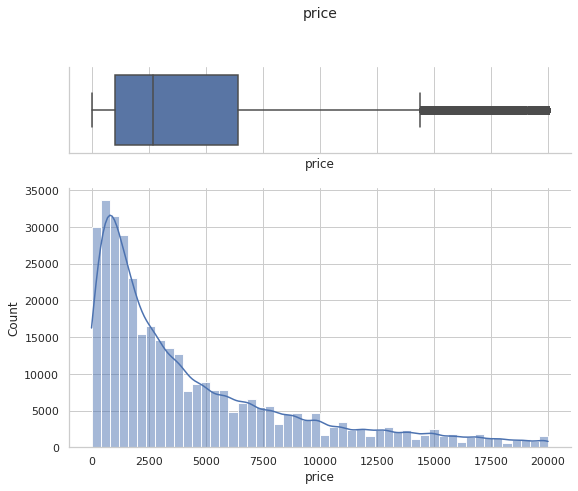


Feature statistics:


,price
count,354369.000000
mean,4416.656776
std,4514.158514
min,0.000000
25%,1050.000000
50%,2700.000000
75%,6400.000000
max,20000.000000


In [10]:
create_visualization(data=data, dtype='target', target='price')

Можно увидеть, что в данных присутствует достаточно много автомобилей со стоимость менее 1050 евро, а также присутствуют автомобили с нулевой стоимостью, что противоречит природе данных.

Сформулируем гипотезы почему в данных присутствуют автомомбили с подобными ценами:
1. Значение 0 устанавливается по умолчанию для автомобилей, владелец которых не выставил цену. В таком случае при рассмотрении среза данных с низкими ценами мы сможем увидеть пик в 0 и разрыв до относительно низких цен в районе 500 евро, а 0 можно рассматривать как пропуск данных с последующей обработкой.
2. В данных присутствуют аномалии, либо нерелевантные наблюдения. В таком случае, за неимением возможности уточнить природу таких значений цен, следует отбросить подобные наблюдения.

Рассмотрим подробнее распределение цен, меньших 1050 евро.

Visualization of target distribution:

Target: price
Visualization of target distribution:

Target: price


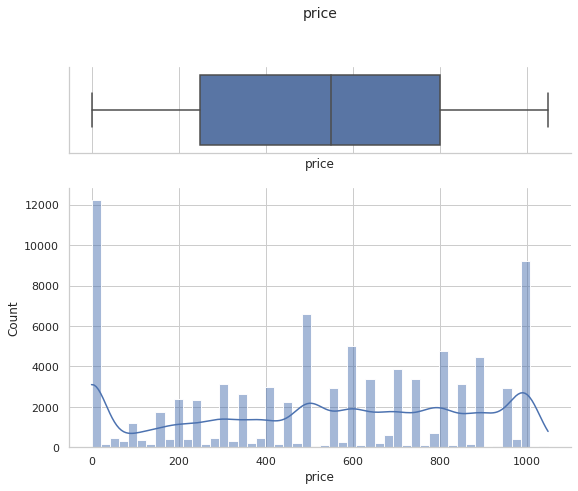


Feature statistics:


,price
count,88057.000000
mean,531.086910
std,328.654481
min,0.000000
25%,250.000000
50%,550.000000
75%,800.000000
max,1049.000000


In [11]:
create_visualization(data=data.query('price < 1050'), dtype='target',
                     target='price')

Можно увидеть, что среди цен в выбранном срезе присутствует несколько пиков в значения 0, 500 и 1000, с распределнием других цен между признаками. Поскольку в данных присутствуют аномально низкие цены для автомобилей (от 0 до 550 евро), мы можем отвергнуть гипотезу о том, что 0 - значение устанавливаемое по умолчанию, а значит мы можем принять гипотезу об аномальности и нерелевантности низких цен.

Отбросим из данных наблюдения, целевой признак которых меньше 550 евро.

Visualization of target distribution:

Target: price
Visualization of target distribution:

Target: price


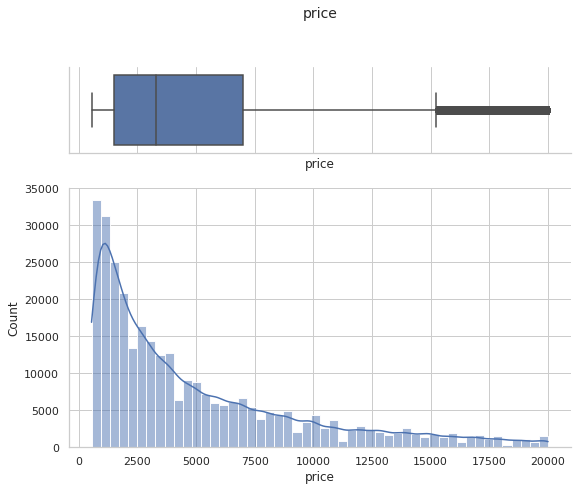


Feature statistics:


,price
count,312361.000000
mean,4978.828509
std,4521.867881
min,550.000000
25%,1500.000000
50%,3300.000000
75%,6999.000000
max,20000.000000


In [12]:
create_visualization(data=data.query('price >= 550'), dtype='target',
                     target='price')

Распределение целевого признака стало более релевантным. Продолжим дальнейшее изучение данных только для наблюдений со значением целевого признака большим или равным 550 евро.

### Анализ количественных признаков

Поскольку решаемае в данном проекте задача - задача регресси, а целевой признак представляется множеством значений цен, для анализа колличественных параметров в разразе разных значений целевого признака, разобъем столбец `price` на четыре категории, в соответсвии со срезами целевых значений по квантилям: [0-25]%, (25-50]%, (50-75]% и (75-100]%.

In [13]:
q_data = data.query('price >= 550').copy()

q_data['price_cats'] = pd.qcut(data['price'], 4)
q_data['price_cats'].unique()

[(6400.0, 20000.0], (1050.0, 2700.0], (2700.0, 6400.0], (-0.001, 1050.0]]
Categories (4, interval[float64, right]): [(-0.001, 1050.0] < (1050.0, 2700.0] < (2700.0, 6400.0] <
                                           (6400.0, 20000.0]]

Рассмотрим колличественных признаки в разрезе категорий целевого признака.

#### registration year

Visualization of quantitative features distribution:

Feature: registration_year


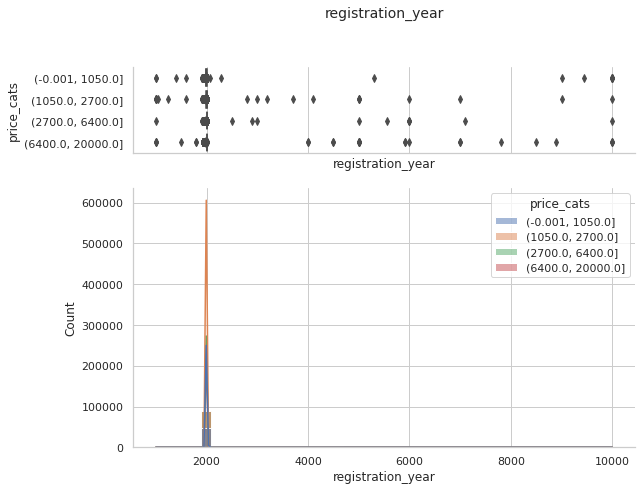


Feature statistics:


,registration_year
count,312361.00
mean,2004.23
std,64.36
min,1000.00
25%,2000.00
50%,2004.00
75%,2008.00
max,9999.00


In [14]:
create_visualization(data=q_data[['registration_year', 'price_cats']],
                     dtype='numbers', target='price_cats')

Видно, что в данных присутствуют серьезные аномалии - минимальный год выпуска автомобиля - 1000, а также в данных присутствуют автомобили, выпущенные в будущем.

Сведем данные и подсчитаем количество разных годов выпуска.

In [15]:
q_data['registration_year'].value_counts().reset_index().sort_values(by='index')

,index,registration_year
68,1000,10
125,1001,1
104,1039,1
111,1234,1
121,1400,1
...,...,...
122,8500,1
113,8888,1
91,9000,2
119,9450,1


Видно, что до 1980 года встречаются единичные автомобили, а аномалии с выпущенными автомобилями в будущем появляются после 2019 года.

Установим границы для данных начиная от 1980 и заканчивая 2019 годом.
Несмотря на то, что дата выгрузки данных ограничивается 2016 годом, рассмотрим и распределение ошибочных данных для учета в дальнейшей обработки.

Visualization of quantitative features distribution:

Feature: registration_year


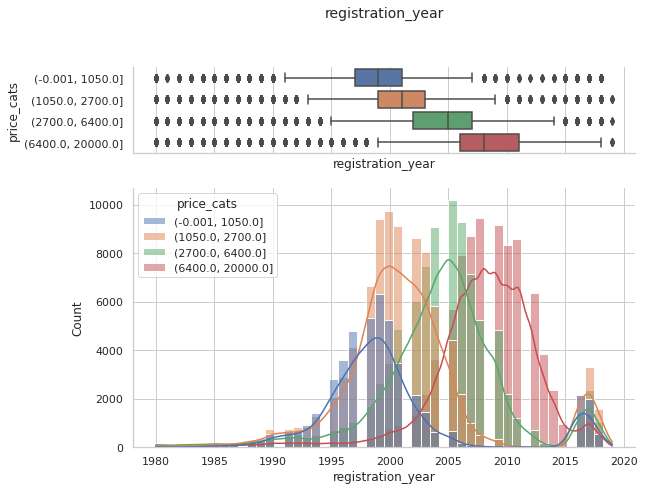


Feature statistics:


,registration_year
count,309378.00
mean,2003.89
std,6.37
min,1980.00
25%,2000.00
50%,2004.00
75%,2008.00
max,2019.00


In [16]:
q_data['registration_year'] = q_data['registration_year'].apply(
    lambda x: np.nan if x > 2019 or x < 1980 else x)

create_visualization(data=q_data[['registration_year', 'price_cats']],
                     dtype='numbers', target='price_cats')

Данные приобрели релевантный вид, и стало отчетливо видно, что между ценой и годом выпуска присутствует прямая связь: чем современней автомобиль, тем выше его стоимость.

#### power

Visualization of quantitative features distribution:

Feature: power


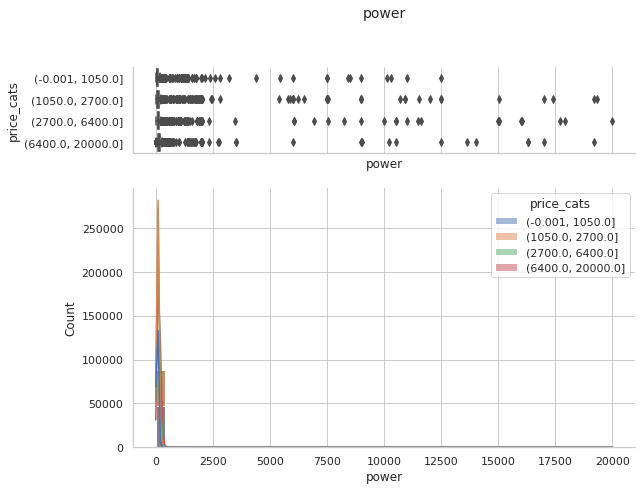


Feature statistics:


,power
count,312361.00
mean,115.68
std,189.00
min,0.00
25%,75.00
50%,109.00
75%,147.00
max,20000.00


In [17]:
create_visualization(data=q_data[['power', 'price_cats']], dtype='numbers',
                     target='price_cats')

В данных присутствуют схожие аномалии. В наблюдениях есть автомобили:
- с нулевой мощностью двигателя;
- с крайне высокой мощностью двигателя.

Аналогично предыдущему признаку, сведем данные и определим количество повторений тех или иных значений мощности двигателя.

In [18]:
q_data['power'].value_counts().reset_index().sort_values(by='index')

,index,power
0,0,27556
265,1,16
305,2,9
311,3,8
237,4,28
...,...,...
552,17932,1
651,19208,1
644,19211,1
481,19312,1


Выбросы начинаются при значениях поля `power` больших 300. Визуализируем их.

Visualization of quantitative features distribution:

Feature: power


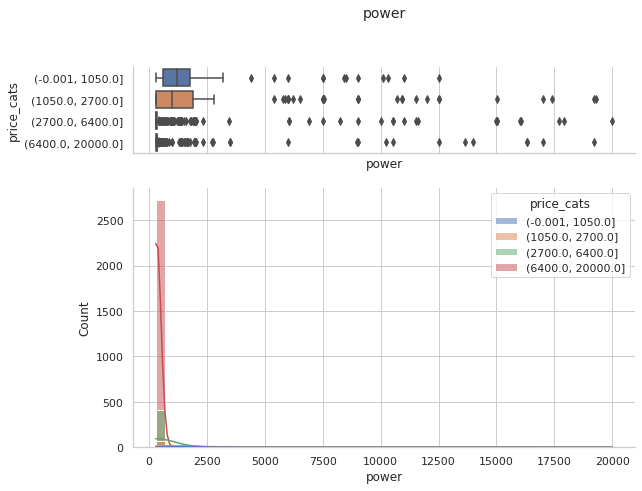


Feature statistics:


,power
count,3504.00
mean,629.72
std,1620.06
min,300.00
25%,306.00
50%,333.00
75%,367.00
max,20000.00


In [19]:
create_visualization(data=q_data.query('power >= 300')[['power', 'price_cats']],
                     dtype='numbers', target='price_cats')

Никаких закономерностей не обноружено, что позволяет сделать вывод, что данные выбросы нерепрезентативны и представляют собой аномалию, от которой необходимо избавиться.

Теперь рассмотрим относительно низкие значения мощности двигателя.

Visualization of quantitative features distribution:

Feature: power


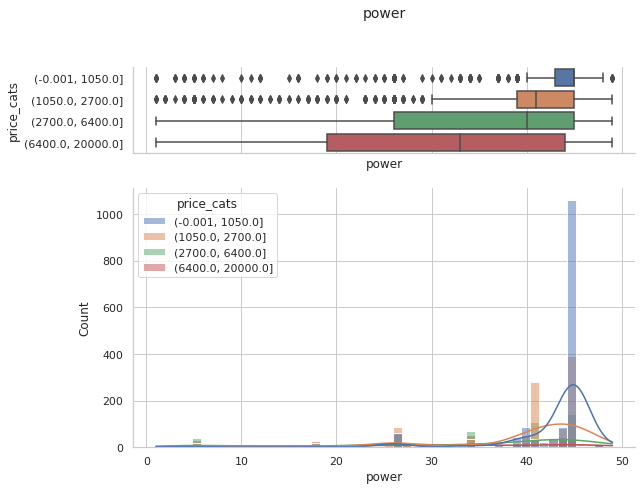


Feature statistics:


,power
count,3888.00
mean,37.99
std,11.17
min,1.00
25%,34.00
50%,44.00
75%,45.00
max,49.00


In [20]:
create_visualization(
    data=q_data.query('power < 50 & power > 0')[['power', 'price_cats']],
    dtype='numbers', target='price_cats')

Значения ниже 40 встречаются крайне редко, при этом обнаружена отрицательная прямая связь между стоимость автомобиля и мощностью его двигателя: чем дороже автомобиль, тем ниже его мощность двигателя. Можно сделать вывод, что такие значения также являются аномалиями.

Рассмотрим параметр, исключив значения меньше 40 и больше 300.

Visualization of quantitative features distribution:

Feature: power


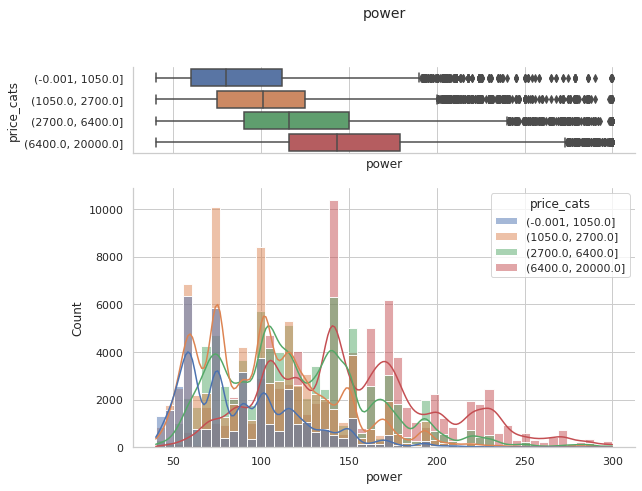


Feature statistics:


,power
count,280345.00
mean,121.14
std,48.43
min,40.00
25%,82.00
50%,115.00
75%,150.00
max,300.00


In [21]:
q_data['power'] = q_data['power'].apply(
    lambda x: np.nan if x < 40 or x > 300 else x)

create_visualization(data=q_data[['power', 'price_cats']], dtype='numbers',
                     target='price_cats')

После удаления аномальных значений, параметр принял более наглядную форму и проявилась прямая зависимость между ценой автомобиля и мощностью его двигателя.

#### kilometer

Visualization of quantitative features distribution:

Feature: kilometer


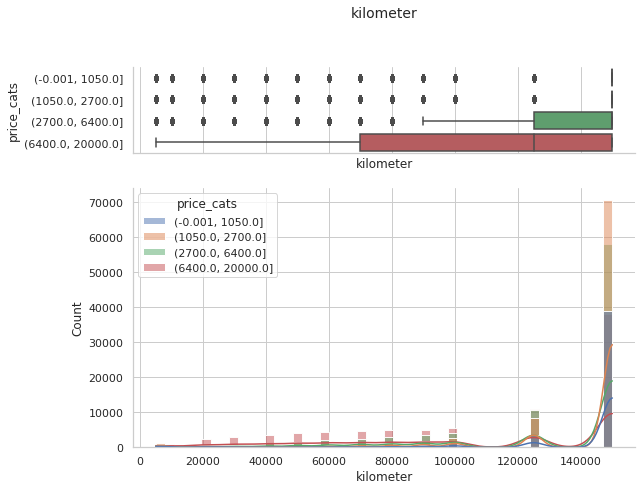


Feature statistics:


,kilometer
count,312361.00
mean,127823.11
std,37296.66
min,5000.00
25%,125000.00
50%,150000.00
75%,150000.00
max,150000.00


In [22]:
create_visualization(data=q_data[['kilometer', 'price_cats']], dtype='numbers',
                     target='price_cats')

Аномалий в данном параметре не обноружено, однако в данных присутствуют выбросы, а сами данных имеют значительные пробелы между значениями, что делает параметр скорее категориальным, чем количественным.

#### registration month

Visualization of quantitative features distribution:

Feature: registration_month


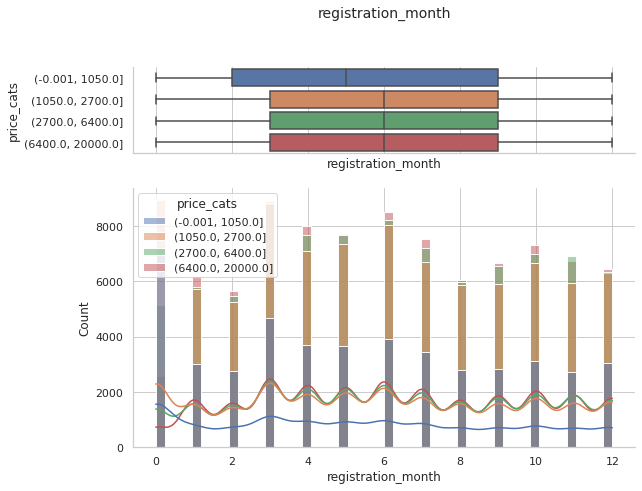


Feature statistics:


,registration_month
count,312361.00
mean,5.93
std,3.64
min,0.00
25%,3.00
50%,6.00
75%,9.00
max,12.00


In [23]:
create_visualization(data=q_data[['registration_month', 'price_cats']],
                     dtype='numbers', target='price_cats')

#### number of pictures

In [24]:
data['number_of_pictures'].unique()

array([0], dtype=int8)

Параметр состоит из одного значения, что делает его нерелевантным для цели проекта.

При формировании датасета данный параметр должен быть отброшен

### Корреляционный анализ

Рассмотрим взаимосвязь между параметрами и целевым признаком с помощью корреляционного анализа.

Проверим взаимосвязи на оригинальных и предобработанных данных для определения эффективности предобоработки: если предобработка корректна, то независимые количественные параметры должны усилить свои взаимосвязи с ценой автомобиля.

#### Корреляция Пирсона

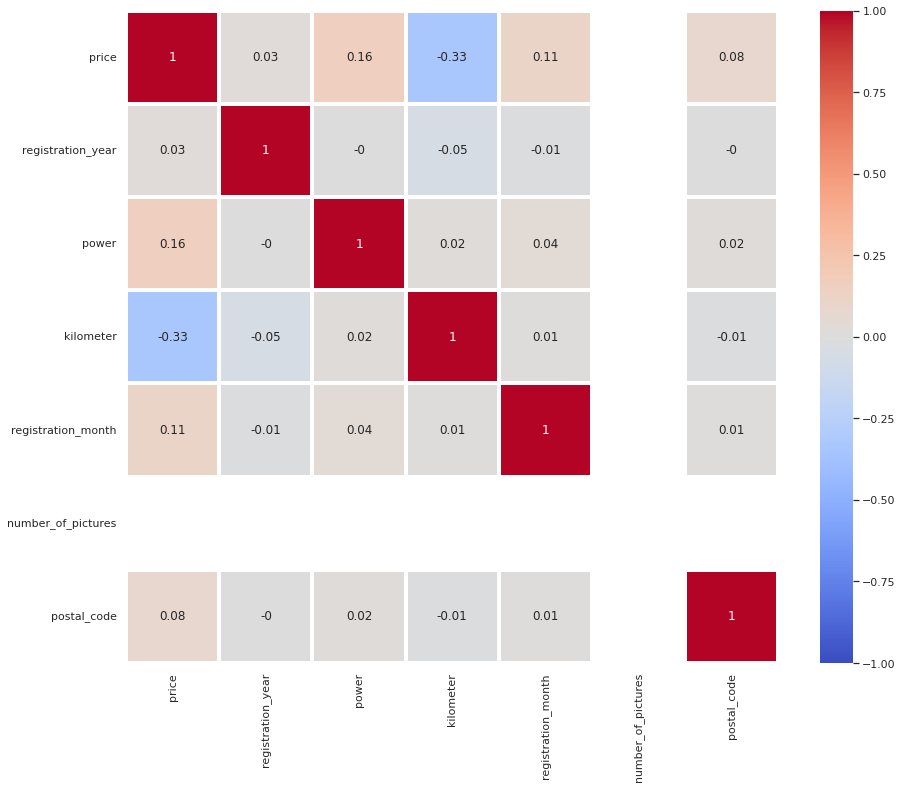

In [25]:
get_corr_map(data)

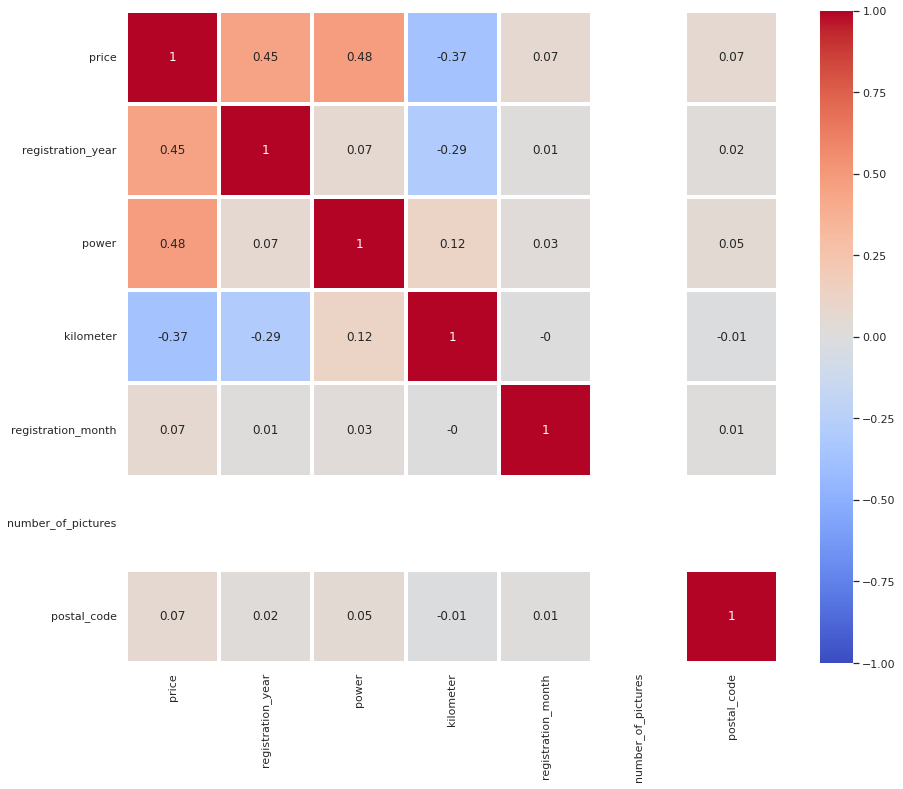

In [26]:
get_corr_map(q_data)

#### Корреляция Спирмана

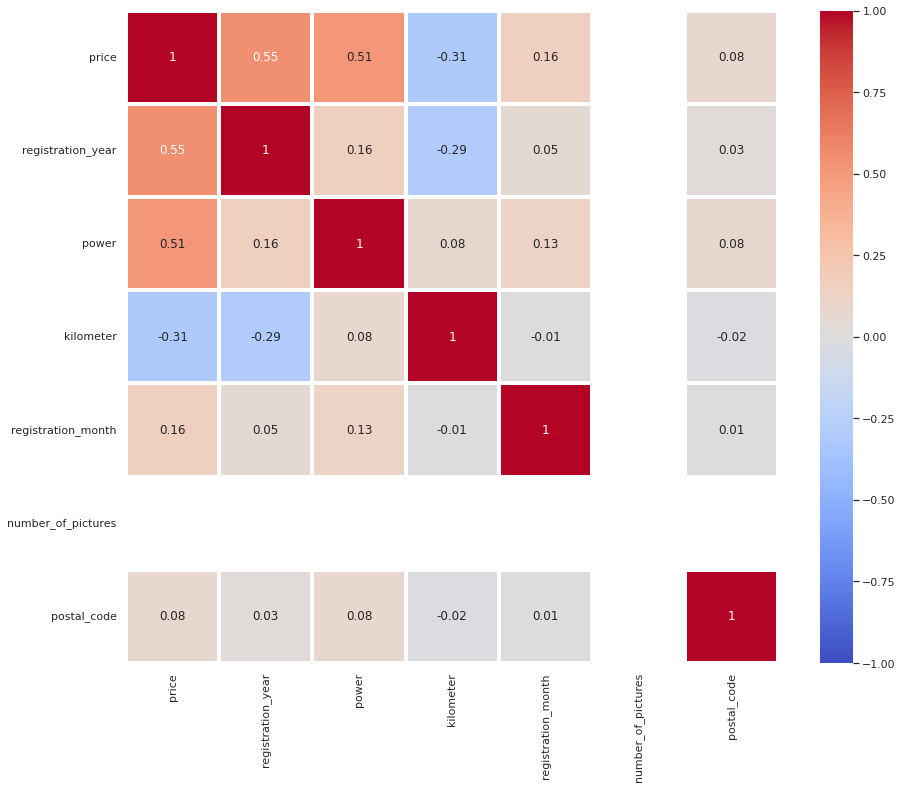

In [27]:
get_corr_map(df=data, method='spearman')

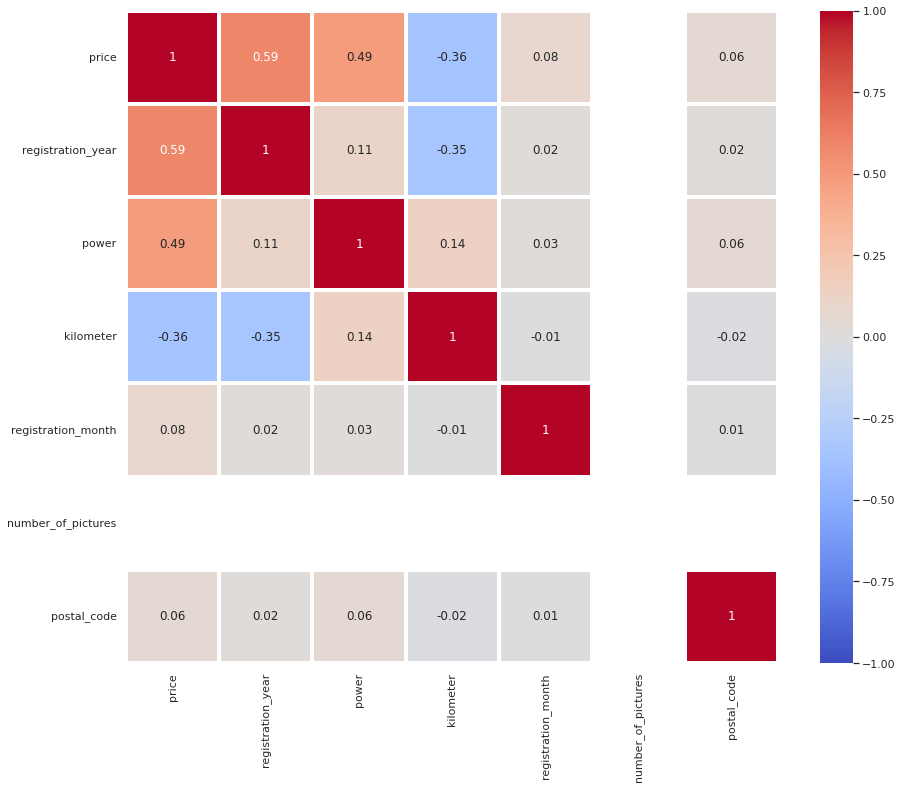

In [28]:
get_corr_map(df=q_data, method='spearman')

Корреляция у целевого признака и независимых количественных параметров значительно выше у обработанных данных, при этом признаки слабо коррелированы между собой, что говорит о незначительной ковариации параметров.

### Анализ категориальных признаков

Проведем анализ категориальных признаков для данных с целевым признаком выше 550.

Поскольку в данных присутствуют пропуски, которые могут представлять из себя отдельную категорию данных, заполним их временным значением "NA".

Для определения наличия зависимостей у категориальных признаков и цены автомобиля, рассмотрим также средние значения целевого признака для каждой категории.

In [29]:
cat_data = (q_data
            .query('price >= 550')
            .drop('price_cats', axis=1)
            .fillna('NA')
            .copy())

In [30]:
del q_data

#### date crawled

Рассмотрим даты скачивания анкеты из базы для проверки наличия аномалий. Несмотря на то, что для обучения этот параметр не должен использоваться, в нем всё равно могут присутствовать ошибки, которые могут портить данные, и от которых необходимо будет избавиться.

Visualization of categorical features and target prevalence:

Feature: date_crawled


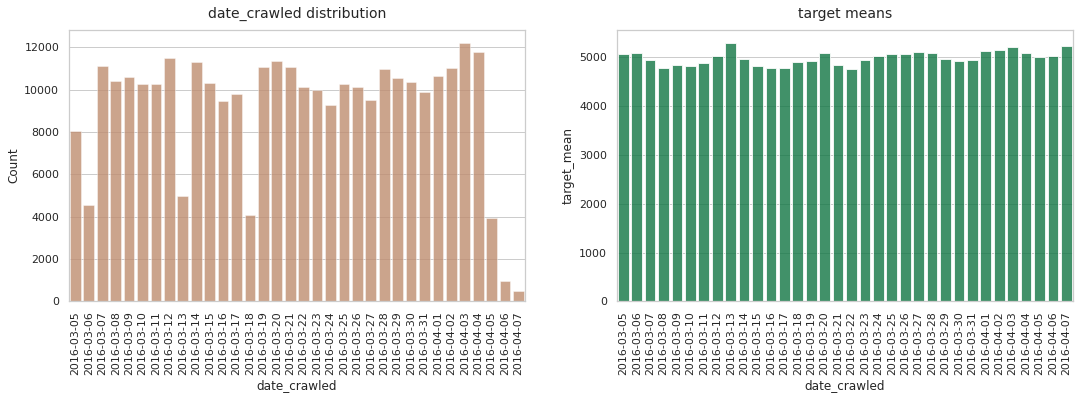

In [31]:
create_visualization(data=cat_data[['date_crawled', 'price']],
                     dtype='categories', target='price')

Несмотря на низкие значения анкет в датах "2016-03-06", "2016-03-14", "2016-03-18" и дат после "2016-04-05", серьезных аномалий или сильных пиков средних цен не обнаружено.

#### vehicle type

Visualization of categorical features and target prevalence:

Feature: vehicle_type


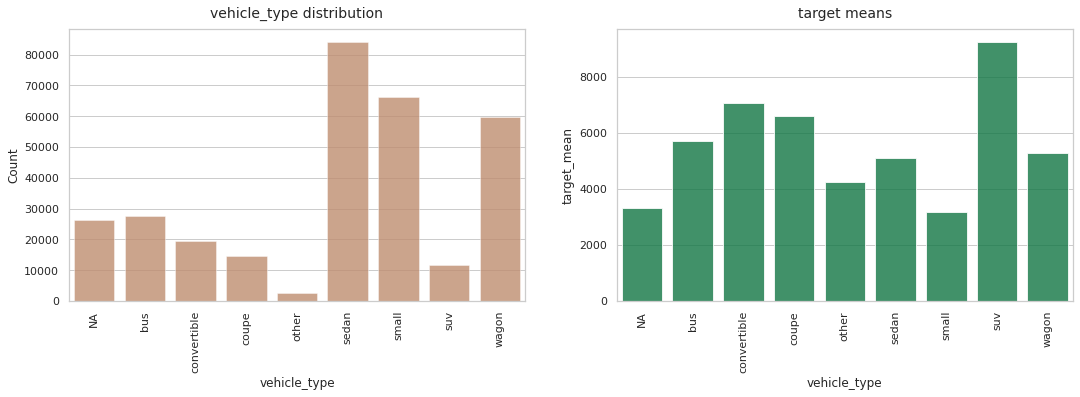

In [32]:
create_visualization(data=cat_data[['vehicle_type', 'price']],
                     dtype='categories', target='price')

Видно, что каждая категория, включая пропуски значительно отличается от прочих: так, самые высокая средняя цена у кроссоверов, а самые низкие у небольших автомобилей.  

Данный признак можно назвать потенциально полезным для обучения модели.

#### registration year

Visualization of categorical features and target prevalence:

Feature: registration_year


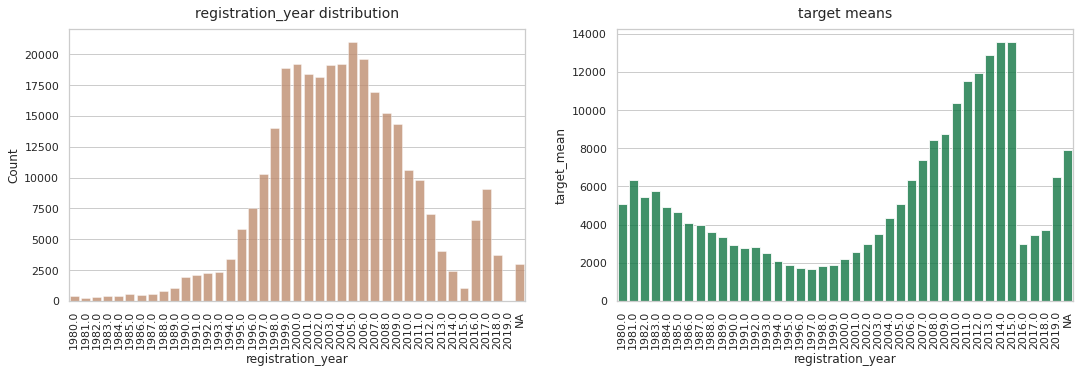

In [33]:
cat_data['registration_year'] = (cat_data['registration_year']
                                 .astype('string')
                                 .astype('object'))

create_visualization(data=cat_data[['registration_year', 'price']],
                     dtype='categories', target='price')

В данных присутствует аномалия: прослеживается четкая взаимосвязь в распределении автомобилей по годам выпуска (наибольшее количество объявлений у автомобилей 1995-2012 годов выпуска с плавным снижением в обе стороны) и взаимосвязь года выпуска автомобиля и его цены (ретро-модели стоят дорого, тогда как "устаревшие" авто 1990-х самое низкое, а после 2000 года стоимость автомобилей резко растет), однако после 2015 года крайне резко возрастает количество автомобилей, а их цена неожиданно и неестественно падает.

Также стоит отметить, что в параметре `date_created`, отвечающим за дату создания анкеты, заканчивается в 2016 году, что говорит о наличии ошибки в данных.

За неимением возможности проверить данные, представим их как аномалию, которую можно обработать: заменим год выпуска для автомобилей, отмеченных в данных выпущенными после 2015 года, на средний год выпуска и рассмотрим изменение распределений количества объявлений и средних цен.

In [34]:
cat_data['registration_year'] = (cat_data['registration_year']
                                 .replace('NA', np.nan)
                                 .apply(
                                     lambda x: np.nan if float(x) > 2015 else x)
                                 .fillna('NA'))

mean_reg_year = round(
    cat_data['registration_year'].replace('NA', np.nan).astype('float').mean())

mean_reg_year

2003

Visualization of categorical features and target prevalence:

Feature: registration_year


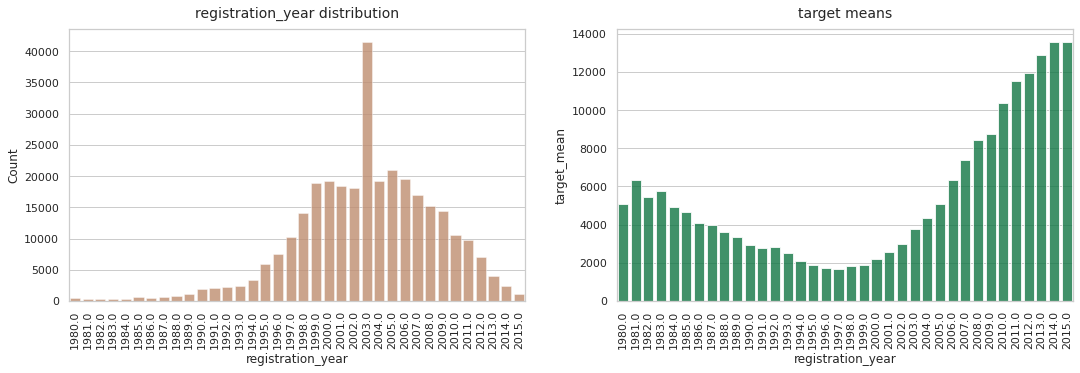

In [35]:
cat_data['registration_year'] = (cat_data['registration_year']
                                 .replace('NA', np.nan)
                                 .fillna(mean_reg_year)
                                 .astype('float32')
                                 .astype('object'))

create_visualization(data=cat_data[['registration_year', 'price']],
                     dtype='categories', target='price')

Видно, что несмотря на резкое увеличение авто с 2003 годом выпуска, средняя стоимость авто стала распределяться менее аномально.

Можно утверждать, что данный признак будет сильно влиять на значение целевого параметра, а значит он должен быть включен в датасет.

#### gearbox

Visualization of categorical features and target prevalence:

Feature: gearbox


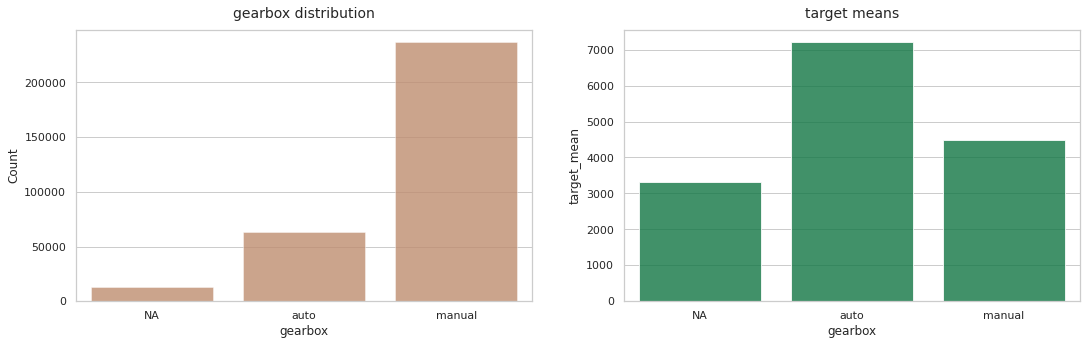

In [36]:
create_visualization(data=cat_data[['gearbox', 'price']], dtype='categories',
                     target='price')

Виды каробки передач также значительно различаются: наиболее дорогие авто с автоматической коробкой. Поскольку в реальности существуют и другие виды коробки передач, пропуски стоит выделить в отдельную категорию.

Данный признак можно назвать потенциально полезным для обучения модели.

#### model

Visualization of categorical features and target prevalence:

Feature: model


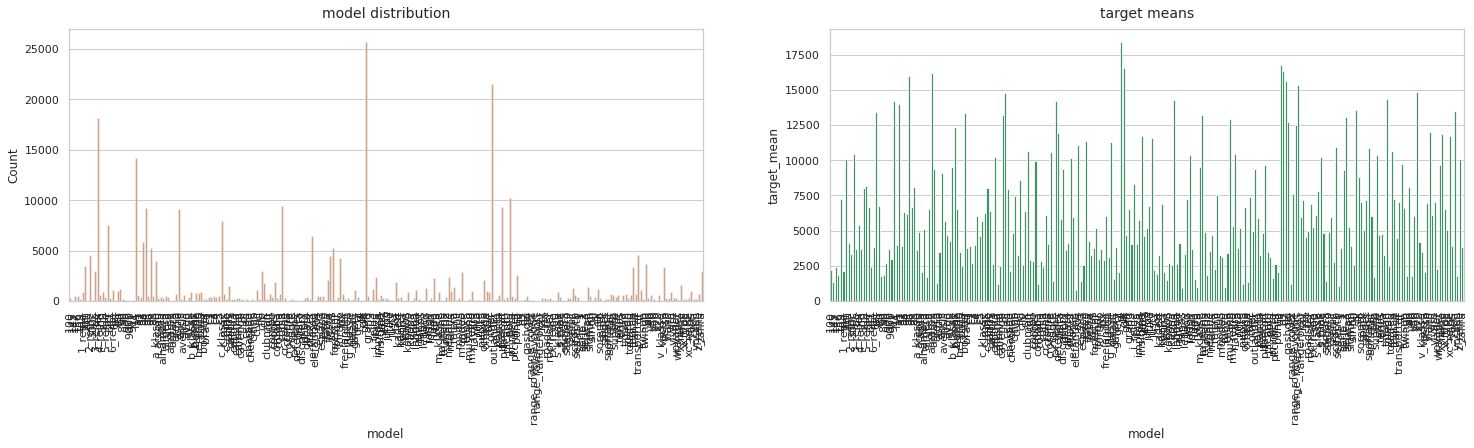

In [37]:
create_visualization(data=cat_data[['model', 'price']], dtype='categories',
                     target='price', figsize=(25, 5))

В данных представлено множество моделей с разной степенью представленности и сильно различающимися средними ценами.

В первую очередь для анализа рассмотрим пропуски как категорию и сравним с категорией  "other", чтобы сравнить схожесть пропусков и "прочих моделей" авто, а также отсортируем модели по цене для более наглядного анализа.

Visualization of categorical features and target prevalence:

Feature: model


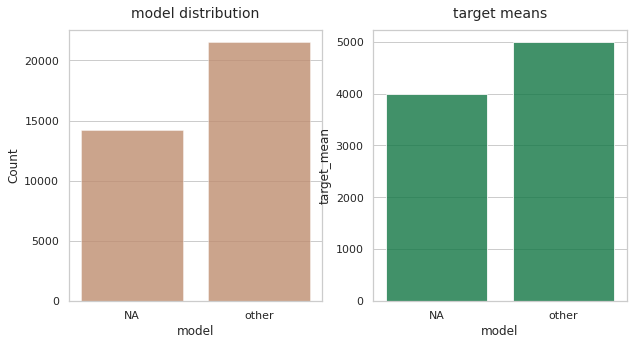

In [38]:
create_visualization(
    data=cat_data.query('model == "NA" | model == "other"')[['model', 'price']],
    dtype='categories', target='price', figsize=(10, 5))

Пропущенные значения значительно отличаются от "other", что обуславливает их выделение в дополнительную категорию.

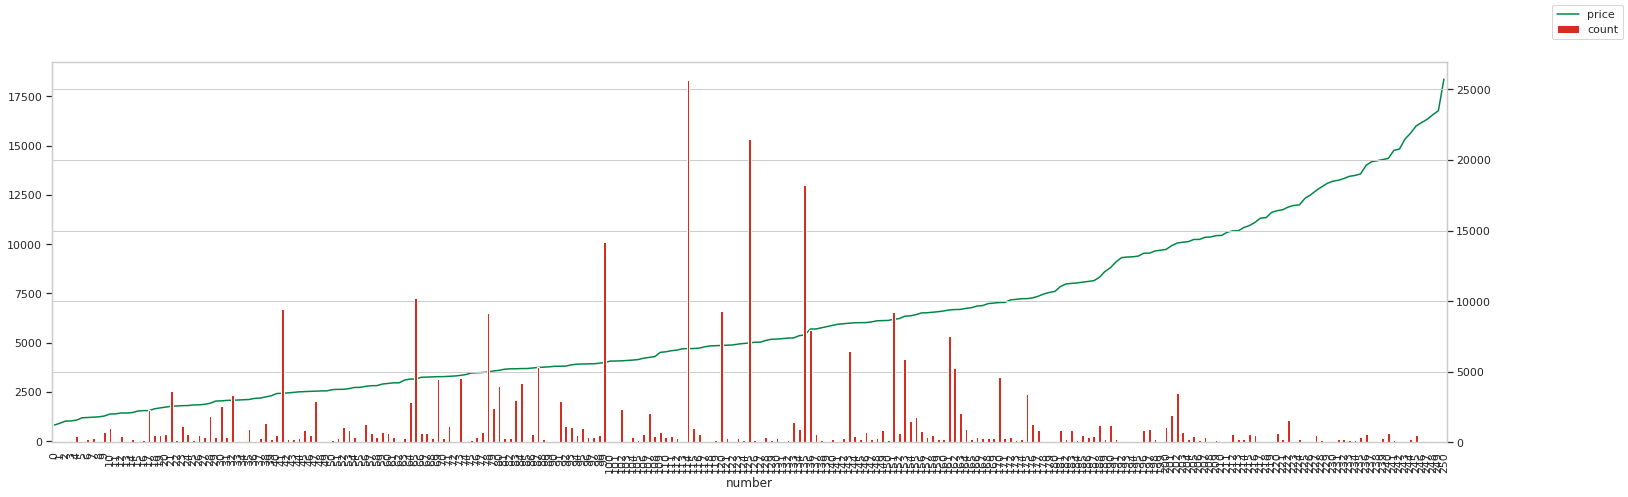

,number,model,count,price
0,0,elefantino,6,819.833333
1,1,lanos,45,911.333333
2,2,move,29,1018.206897
3,3,lybra,35,1027.514286
4,4,seicento,448,1071.904018
...,...,...,...,...
246,246,amarok,12,16172.916667
247,247,q5,94,16340.351064
248,248,glk,62,16570.822581
249,249,q3,12,16769.833333


In [39]:
models_info = sort_price(cat_data, index='model', values=['brand', 'price'])

models_info

После сортировки моделей по цене, можно увидеть возможности группировки моделей по ценовым группам.

Сгруппируем модели по их стоимости в 10 групп с помощью биннинга по квантилям цены.

In [40]:
price_qs = [round(
    models_info['price'].quantile(q=x/100)) for x in range(10, 101, 10)]

models_info['groups'] = models_info['price'].apply(get_ten_qbins)
models_info

,number,model,count,price,groups
0,0,elefantino,6,819.833333,0-10
1,1,lanos,45,911.333333,0-10
2,2,move,29,1018.206897,0-10
3,3,lybra,35,1027.514286,0-10
4,4,seicento,448,1071.904018,0-10
...,...,...,...,...,...
246,246,amarok,12,16172.916667,90-100
247,247,q5,94,16340.351064,90-100
248,248,glk,62,16570.822581,90-100
249,249,q3,12,16769.833333,90-100


Теперь создадим для каждой группы списки значений моделей и получим 10 ценовых групп разных моделей автомобилей.

In [41]:
models_0_10 = list(models_info[models_info['groups'] == '0-10']['model'])
models_10_20 = list(models_info[models_info['groups'] == '10-20']['model'])
models_20_30 = list(models_info[models_info['groups'] == '20-30']['model'])
models_30_40 = list(models_info[models_info['groups'] == '30-40']['model'])
models_40_50 = list(models_info[models_info['groups'] == '40-50']['model'])
models_50_60 = list(models_info[models_info['groups'] == '50-60']['model'])
models_60_70 = list(models_info[models_info['groups'] == '60-70']['model'])
models_70_80 = list(models_info[models_info['groups'] == '70-80']['model'])
models_80_90 = list(models_info[models_info['groups'] == '80-90']['model'])
models_90_100 = list(models_info[models_info['groups'] == '90-100']['model'])

Данный признак имеет сильную взаимосвязь с целевым признаком, поэтому он должен быть включен в датасет.

#### registration month

Visualization of categorical features and target prevalence:

Feature: registration_month


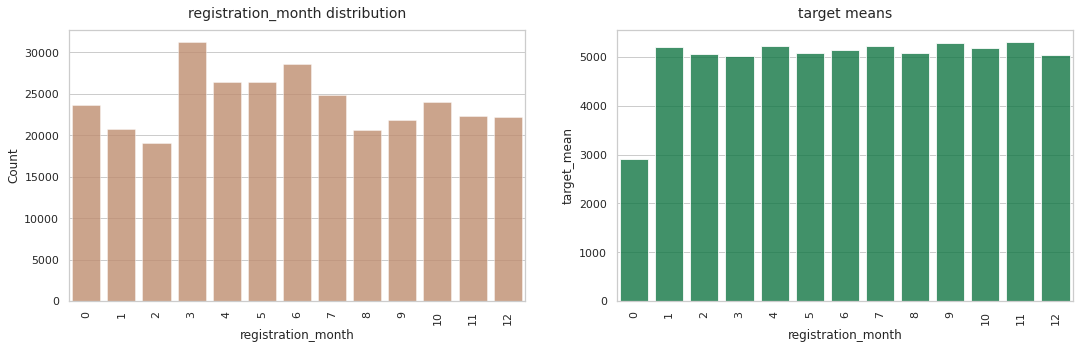

In [42]:
cat_data['registration_month'] = cat_data['registration_month'].astype('object')

create_visualization(data=cat_data[['registration_month', 'price']],
                     dtype='categories', target='price')

Вцелом сильной зависимости у цены и месяца регистрации атомобиля нет, за исключением января, в котором средняя цена ниже почти в два раза, чем в других месяцах, что является аномалией, но из-за невозможности проверки данных в рамках данного проекта можно объяснить такую особенность экономическими циклами в начале года.

Включим признак в датасет.

#### fuel type

Visualization of categorical features and target prevalence:

Feature: fuel_type


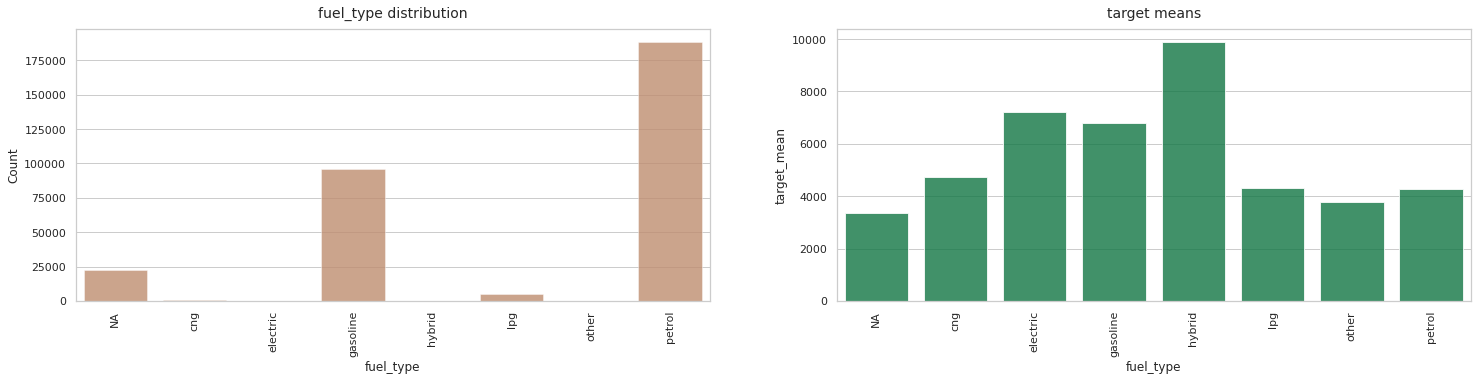

petrol      188275
gasoline     95665
NA           22489
lpg           4973
cng            531
hybrid         223
other          122
electric        83
Name: fuel_type, dtype: int64

In [43]:
create_visualization(data=cat_data[['fuel_type', 'price']], dtype='categories',
                     target='price', figsize=(25, 5))
cat_data['fuel_type'].value_counts()

В данных очень слабо представлены атомобили с экологичным топливом. Объединим их в одну общуу категорию.

Visualization of categorical features and target prevalence:

Feature: fuel_type_grouped


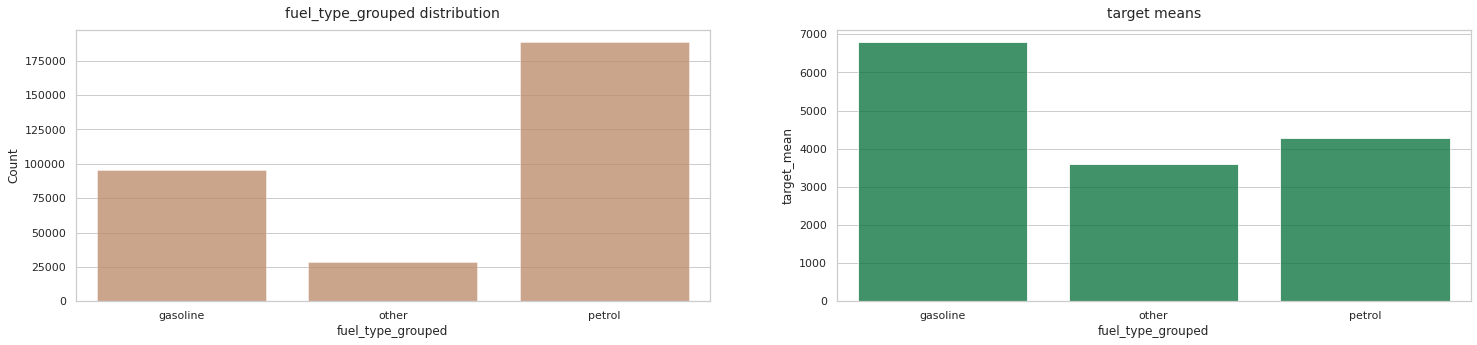

petrol      188275
gasoline     95665
NA           22489
lpg           4973
cng            531
hybrid         223
other          122
electric        83
Name: fuel_type, dtype: int64

In [44]:
rare_types = ['cng', 'lpg', 'hybrid', 'electric', 'other', 'NA']

cat_data['fuel_type_grouped'] = cat_data['fuel_type'].apply(
    lambda x: 'other' if x in rare_types else x)

create_visualization(data=cat_data[['fuel_type_grouped', 'price']],
                     dtype='categories', target='price', figsize=(25, 5))
cat_data['fuel_type'].value_counts()

Предсавленность категорий улучшилось, при этом целевой признак всё ещё сильно зависит от категорий.

Данный признак должен быть включен в датасет.

#### brand

Visualization of categorical features and target prevalence:

Feature: brand


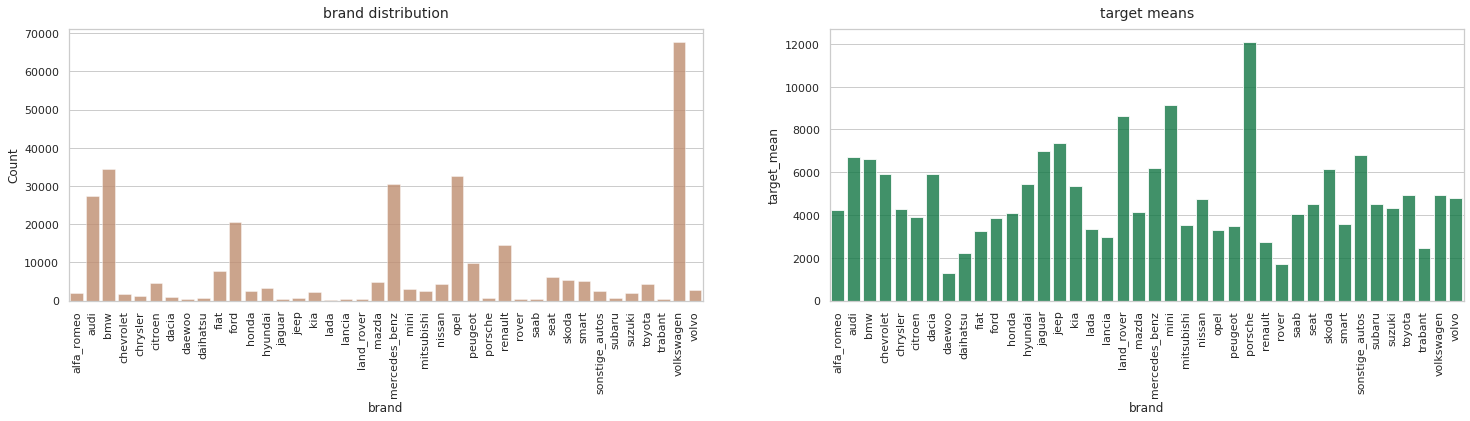

In [45]:
create_visualization(data=cat_data[['brand', 'price']], dtype='categories',
                     target='price', figsize=(25, 5))

У брендов автомобилей похожая ситуация, которая присутствует у моделей авто.

Проведем полностью аналогичную обработку и рассмотрим 10 ценовых категорий брендов.

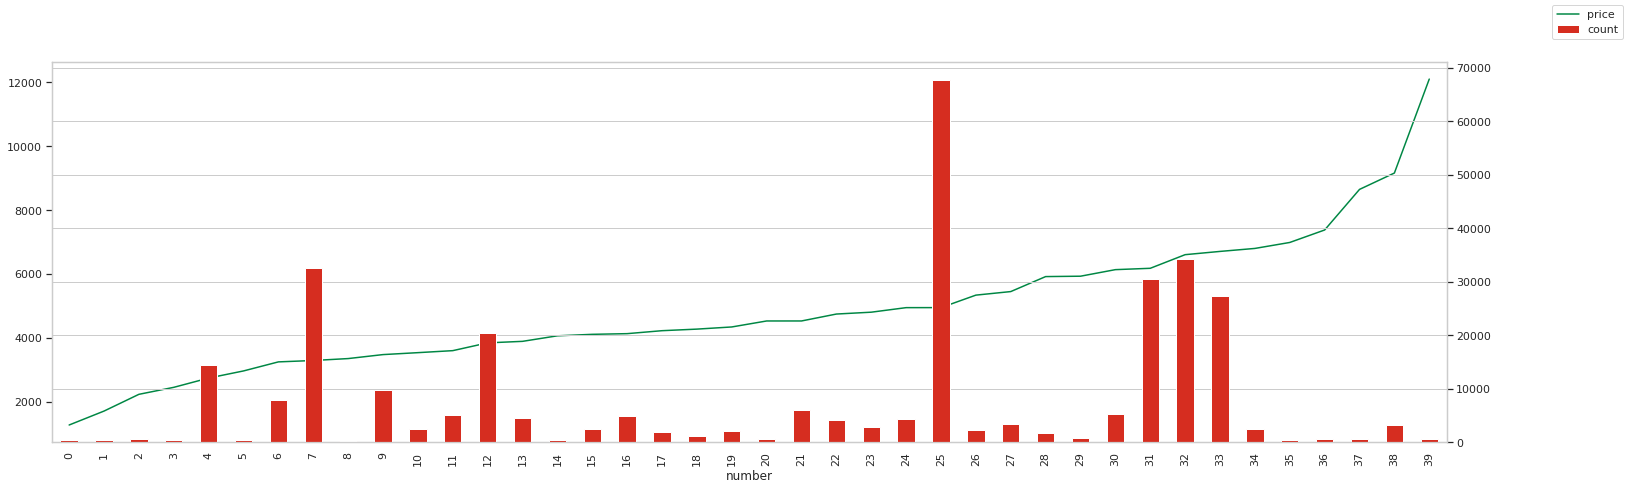

,number,brand,count,price
0,0,daewoo,401,1270.214464
1,1,rover,354,1706.440678
2,2,daihatsu,586,2231.046075
3,3,trabant,375,2450.093333
4,4,renault,14508,2740.610284
5,5,lancia,364,2963.868132
6,6,fiat,7858,3247.245737
7,7,opel,32563,3290.637933
8,8,lada,203,3351.123153
9,9,peugeot,9749,3475.694430


In [46]:
brands_info = sort_price(cat_data, index='brand', values=['power', 'price'])

brands_info

In [47]:
price_qs = [round(
    brands_info['price'].quantile(q=x/100)) for x in range(10, 101, 10)]

brands_info['groups'] = brands_info['price'].apply(get_ten_qbins)
brands_info

,number,brand,count,price,groups
0,0,daewoo,401,1270.214464,0-10
1,1,rover,354,1706.440678,0-10
2,2,daihatsu,586,2231.046075,0-10
3,3,trabant,375,2450.093333,0-10
4,4,renault,14508,2740.610284,10-20
5,5,lancia,364,2963.868132,10-20
6,6,fiat,7858,3247.245737,10-20
7,7,opel,32563,3290.637933,10-20
8,8,lada,203,3351.123153,20-30
9,9,peugeot,9749,3475.694430,20-30


In [48]:
brands_0_10 = list(brands_info[brands_info['groups'] == '0-10']['brand'])
brands_10_20 = list(brands_info[brands_info['groups'] == '10-20']['brand'])
brands_20_30 = list(brands_info[brands_info['groups'] == '20-30']['brand'])
brands_30_40 = list(brands_info[brands_info['groups'] == '30-40']['brand'])
brands_40_50 = list(brands_info[brands_info['groups'] == '40-50']['brand'])
brands_50_60 = list(brands_info[brands_info['groups'] == '50-60']['brand'])
brands_60_70 = list(brands_info[brands_info['groups'] == '60-70']['brand'])
brands_70_80 = list(brands_info[brands_info['groups'] == '70-80']['brand'])
brands_80_90 = list(brands_info[brands_info['groups'] == '80-90']['brand'])
brands_90_100 = list(brands_info[brands_info['groups'] == '90-100']['brand'])

Включим данный признак в датасет в виде ценовых групп брендов.

#### repaired

Visualization of categorical features and target prevalence:

Feature: repaired


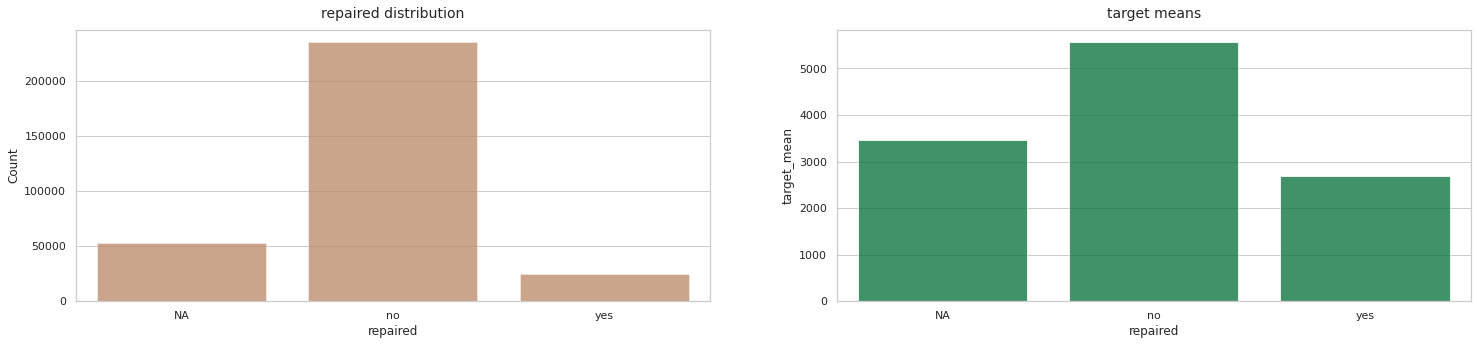

In [49]:
create_visualization(data=cat_data[['repaired', 'price']], dtype='categories',
                     target='price', figsize=(25, 5))

Можно предположить, что пропуски в данных - незаполненные автовладельцем информация о совершившемся ремонте автомобилей, что также объяснят более низку среднюю цену у таких авто по сравнению с авто без ремонтов, но одновременно более высокую среднюю цену, чем отремантированных авто.

Поскольку пристуствует техническая возможность не указывать факт ремонта автомобиля, владельцы, разместившие объявления могут извлекать из реализаций подобных объявлений дополнительную прибыль, а значит пропуск должен рассматриваться как отдельная категория.

Включим данный параметр в датасет.

#### date_created

Visualization of categorical features and target prevalence:

Feature: date_created


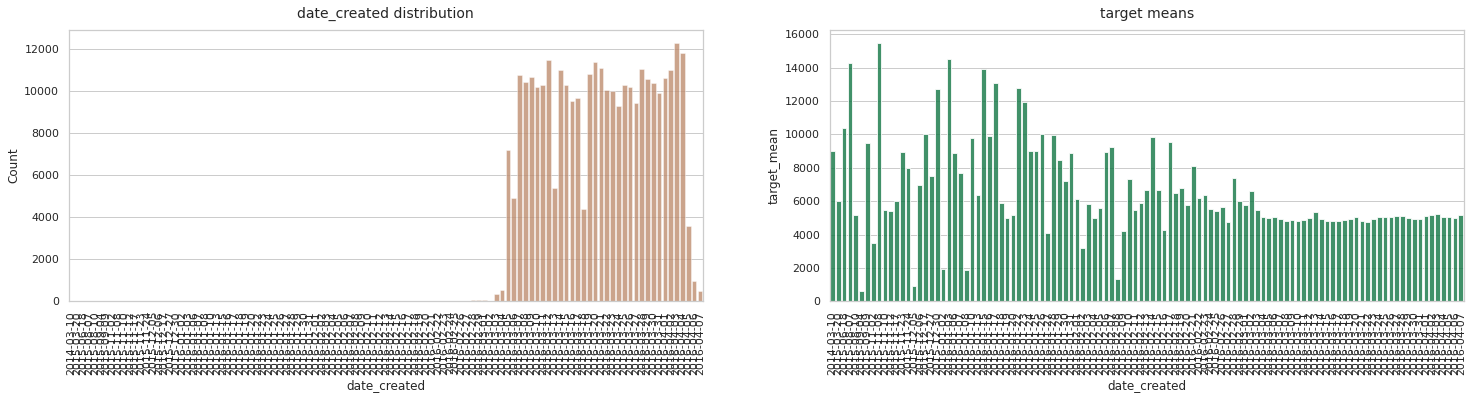

2016-04-03    12282
2016-04-04    11807
2016-03-12    11436
2016-03-20    11373
2016-03-21    11094
              ...  
2016-01-20        1
2015-12-27        1
2015-11-12        1
2015-12-06        1
2015-06-18        1
Name: date_created, Length: 109, dtype: int64

In [50]:
create_visualization(data=cat_data[['date_created', 'price']],
                     dtype='categories', target='price', figsize=(25, 5))

cat_data['date_created'].value_counts()

В данных присутсвует аномально низкие значения для дат до 2016-02-28. Рассмотрим также средние цены и распределения данных по месяцам и по дням недели.

Visualization of categorical features and target prevalence:

Feature: month_created


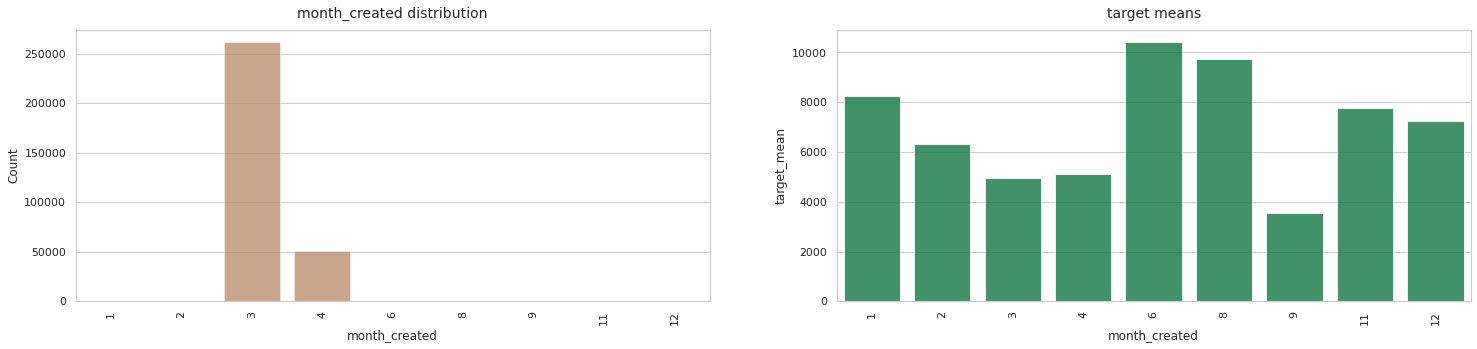

2016-04-03    12282
2016-04-04    11807
2016-03-12    11436
2016-03-20    11373
2016-03-21    11094
              ...  
2016-01-20        1
2015-12-27        1
2015-11-12        1
2015-12-06        1
2015-06-18        1
Name: date_created, Length: 109, dtype: int64

In [51]:
cat_data['month_created'] = pd.to_datetime(cat_data['date_created']).dt.month

create_visualization(data=cat_data[['month_created', 'price']],
                     dtype='categories', target='price', figsize=(25, 5))

cat_data['date_created'].value_counts()

Visualization of categorical features and target prevalence:

Feature: dw_created


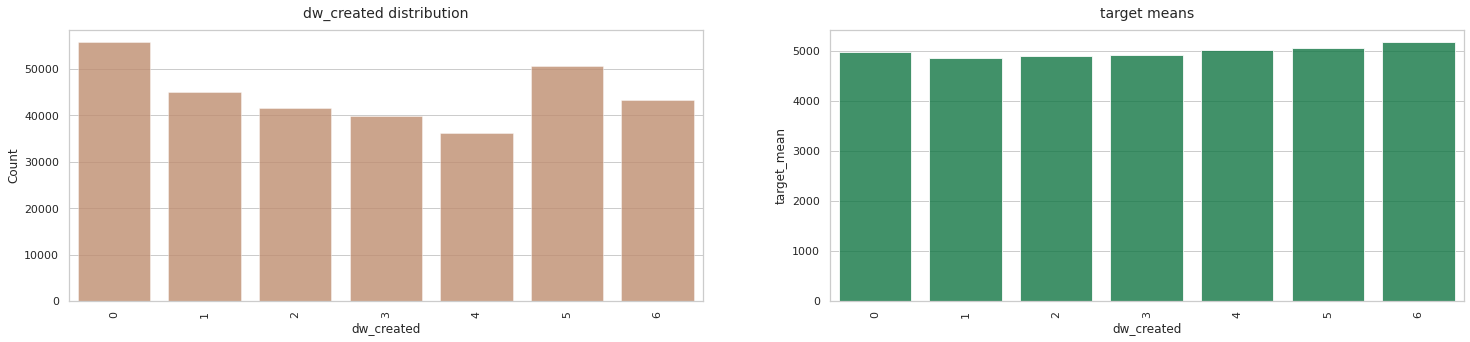

2016-04-03    12282
2016-04-04    11807
2016-03-12    11436
2016-03-20    11373
2016-03-21    11094
              ...  
2016-01-20        1
2015-12-27        1
2015-11-12        1
2015-12-06        1
2015-06-18        1
Name: date_created, Length: 109, dtype: int64

In [52]:
cat_data['dw_created'] = pd.to_datetime(cat_data['date_created']).dt.dayofweek

create_visualization(data=cat_data[['dw_created', 'price']],
                     dtype='categories', target='price', figsize=(25, 5))

cat_data['date_created'].value_counts()

Каких-либо значимых закномерностей не обнаружено.

Рассмотрим только частовстречающиеся данные.

In [53]:
cat_data['date_created'] = pd.to_datetime(cat_data['date_created'])

date_ = pd.to_datetime('2016-02-28')
cat_data['date_created'] =  cat_data['date_created'].apply(
    lambda x: np.nan if x < date_ else x)

date_nans = cat_data['date_created'].isna().sum()

print('Null values in date_created:    ', date_nans)
print('Share of the total dataset size:',
      f'{round(date_nans / cat_data.shape[0], 4) * 100} %')

Null values in date_created:     388
Share of the total dataset size: 0.12 %


Visualization of categorical features and target prevalence:

Feature: dw_created


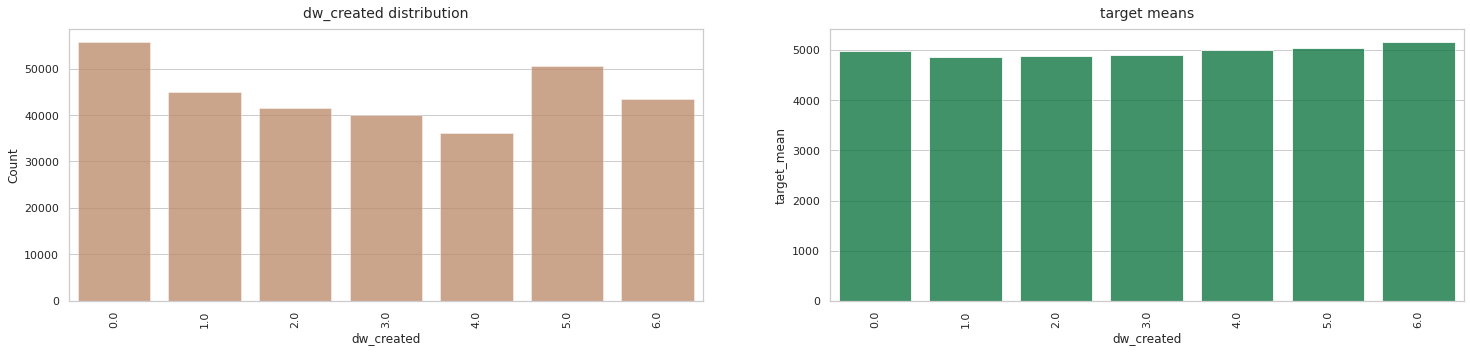

2016-04-03    12282
2016-04-04    11807
2016-03-12    11436
2016-03-20    11373
2016-03-21    11094
2016-03-28    11022
2016-04-02    10998
2016-03-14    10978
2016-03-19    10767
2016-03-07    10744
2016-03-09    10626
2016-04-01    10595
2016-03-29    10565
2016-03-08    10393
2016-03-30    10343
2016-03-15    10289
2016-03-25    10286
2016-03-11    10276
2016-03-10    10195
2016-03-26    10155
2016-03-22    10032
2016-03-23     9979
2016-03-31     9910
2016-03-17     9675
2016-03-16     9507
2016-03-27     9405
2016-03-24     9296
2016-03-05     7201
2016-03-13     5376
2016-03-06     4884
2016-03-18     4378
2016-04-05     3571
2016-04-06      971
2016-03-04      555
2016-04-07      473
2016-03-03      359
2016-02-28       49
2016-03-01       48
2016-02-29       45
2016-03-02       35
Name: date_created, dtype: int64

In [54]:
cat_data['dw_created'] = pd.to_datetime(cat_data['date_created']).dt.dayofweek

create_visualization(data=cat_data[['dw_created', 'price']], dtype='categories',
                     target='price', figsize=(25, 5))

cat_data['date_created'].value_counts()

Поскольку качество автомобиля никак не зависит от дня недели размещения объявления о продаже этого автомобиля, а также ввиду отсутствия взаимосвязи между стоимостью атво и днем недели размещения объявления, отбросим данный признак при формировании датасета.

#### postal code

Разобъем почтовые коды на группы для упращения визуализации и дополнительной группировки.

Visualization of categorical features and target prevalence:

Feature: postal_bins


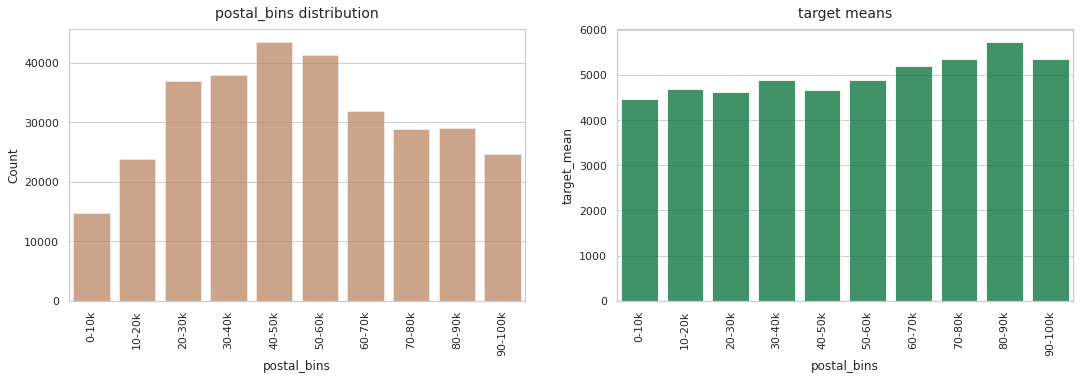

In [55]:
cat_data['postal_bins'] = cat_data['postal_code'].apply(get_postal_bins)

create_visualization(data=cat_data[['postal_bins', 'price']],
                     dtype='categories', target='price')

Включим данный признак в датасет.

#### last seen

Несмотря на то, что данный признак не может определять стоимость автомобиля при создании объявления, поскольку представляет собой "данные из будущего" всё равно рассмотрим его на проверку аномалий.

Visualization of categorical features and target prevalence:

Feature: last_seen


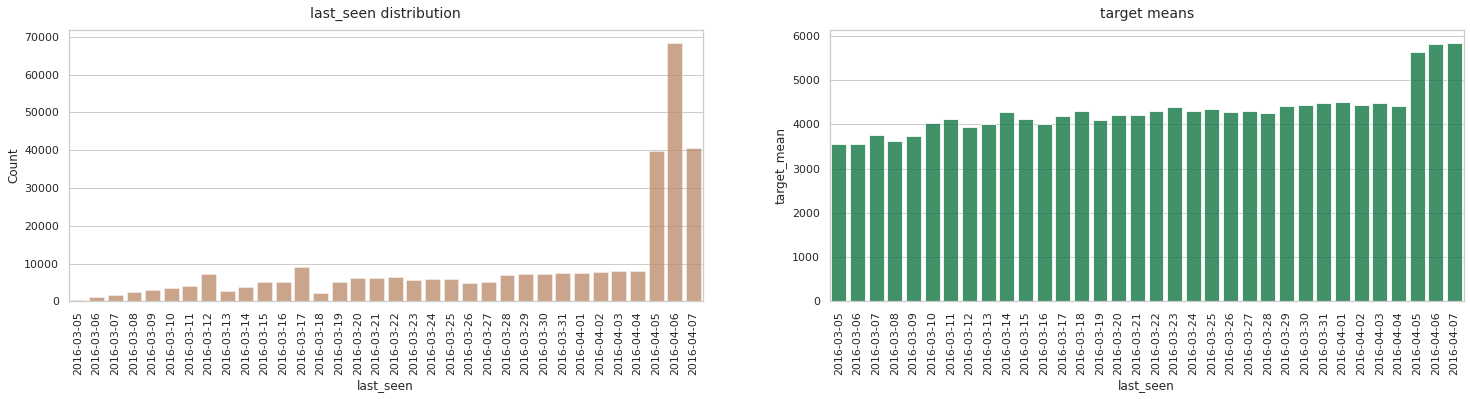

In [56]:
create_visualization(data=cat_data[['last_seen', 'price']], dtype='categories',
                     target='price', figsize=(25, 5))

# Предобработка данных

Исходя из проведенного анализа, проведем следующую обработку данных:
1. Удалим из данных все записи со значением цены меньшим чем 550;
2. Заменим пропусками 

In [57]:
del cat_data

In [58]:
%%time

processed_data = data.query('price >= 550').copy()

processed_data['registration_year'] = (
    processed_data['registration_year']
    .apply(lambda x: np.nan if x > 2015 or x < 1980 else x)
    .fillna(mean_reg_year))

processed_data['power'] = processed_data['power'].apply(
    lambda x: np.nan if x < 40 or x > 300 else x)

processed_data['model'] = processed_data['model'].apply(get_models_bins)

processed_data['fuel_type'] = processed_data['fuel_type'].apply(
    lambda x: 'other' if x in rare_types else x)

processed_data['brand'] = processed_data['brand'].apply(get_brand_bins)

processed_data['postal_code'] = processed_data['postal_code'].apply(
    get_postal_bins)

CPU times: user 1 s, sys: 6.77 ms, total: 1.01 s
Wall time: 1.02 s


# Формирование и анализ датасета

## Формирование датасета

Из обработанных данных сформируем датасет, заполнив все пропуски категорией `Unknown`, после чего проверим датасет на наличие дубликатов и удалим их при обнаружении.

In [59]:
%%time

ds = pd.DataFrame(
    {
        # Categorical features
        'c_vehicle_type':             (processed_data['vehicle_type']
                                       .fillna('Unknown')
                                       .astype('string')
                                       .astype('object')),
        'c_gearbox':                  (processed_data['gearbox']
                                       .fillna('Unknown')
                                       .astype('string')
                                       .astype('object')),
        'c_power':                    (pd.qcut(processed_data['power'], 10
                                               ).astype('string')
                                               .fillna('Unknown')
                                               .astype('string')
                                               .astype('object')),
        'c_model':                    (processed_data['model']
                                       .fillna('Unknown')
                                       .astype('string')
                                       .astype('object')),
        'c_registration_month':       (processed_data['registration_month']
                                       .astype('string')
                                       .astype('object')),
        'c_fuel':                     (processed_data['fuel_type']
                                       .fillna('Unknown')
                                       .astype('string')
                                       .astype('object')),
        'c_brand':                    (processed_data['brand']
                                       .astype('string')
                                       .astype('object')),
        'c_repaired':                 (processed_data['repaired']
                                       .fillna('Unknown')
                                       .astype('string')
                                       .astype('object')),
        'c_postal_code':              (processed_data['postal_code']
                                       .astype('string')
                                       .astype('object')),

        # Quantitative features
        'q_registration_year':        (processed_data['registration_year']
                                       .astype('float16')),
        'q_kilometer':                processed_data['kilometer'],

        # Target
        'target':                     processed_data['price']
    }
)

del processed_data

ds = ds.dropna()

print('Duplicates in data:                         ', ds.duplicated().sum())
ds = ds.drop_duplicates()
print('Duplicates in data after processing:        ', ds.duplicated().sum())
print()

ds = ds.reset_index(drop=True)

cat_features = []
for i in ds.columns:
    if not pd.isna(re.search('^c.*', i)):
        cat_features.append(i)

q_features = list(ds.drop(cat_features, axis=1).columns)[0:-1]

print('DS shape:                                   ', ds.shape)
print('The amount of observations has decreased by:',
      f'{100 - round(ds.shape[0] / data.shape[0] * 100, 2)}%')
print()
print('Cat features:')
print(cat_features)
print()
print('Quantitative features:')
print(q_features)
print()
print('Dataset sample:')
ds.head()

Duplicates in data:                          22739
Duplicates in data after processing:         0

DS shape:                                    (289622, 12)
The amount of observations has decreased by: 18.269999999999996%

Cat features:
['c_vehicle_type', 'c_gearbox', 'c_power', 'c_model', 'c_registration_month', 'c_fuel', 'c_brand', 'c_repaired', 'c_postal_code']

Quantitative features:
['q_registration_year', 'q_kilometer']

Dataset sample:
CPU times: user 1.94 s, sys: 24.9 ms, total: 1.97 s
Wall time: 1.97 s


,c_vehicle_type,c_gearbox,c_power,c_model,c_registration_month,c_fuel,c_brand,c_repaired,c_postal_code,q_registration_year,q_kilometer,target
0,coupe,manual,"(185.0, 300.0]",Unknown,5,gasoline,80-90,yes,60-70k,2011.0,125000,18300
1,suv,auto,"(160.0, 185.0]",60-70,8,gasoline,90-100,Unknown,90-100k,2004.0,125000,9800
2,small,manual,"(60.0, 75.0]",40-50,6,petrol,60-70,no,90-100k,2001.0,150000,1500
3,small,manual,"(60.0, 75.0]",40-50,7,gasoline,70-80,no,60-70k,2008.0,90000,3600
4,sedan,manual,"(90.0, 102.0]",50-60,10,petrol,80-90,yes,30-40k,1995.0,150000,650


In [60]:
analyze_dataframe(ds)

General data analysis:

Shape of the table:      (289622, 12)
Duplicates in the table: 0, (0.0%)
Memory usage:            23.2+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
c_vehicle_type,289622,0,100.0,9,"[wagon, suv, small, sedan, other, coupe, conve...",object
c_gearbox,289622,0,100.0,3,"[manual, auto, Unknown]",object
c_power,289622,0,100.0,11,"[Unknown, (90.0, 102.0], (75.0, 90.0], (60.0, ...",object
c_model,289622,0,100.0,11,"[Unknown, 90-100, 80-90, 70-80, 60-70, 50-60, ...",object
c_registration_month,289622,0,100.0,13,"[9, 8, 7, 6, 5, 4, 3, 2, 12, 11, 10, 1, 0]",object
c_fuel,289622,0,100.0,4,"[petrol, other, gasoline, Unknown]",object
c_brand,289622,0,100.0,10,"[90-100, 80-90, 70-80, 60-70, 50-60, 40-50, 30...",object
c_repaired,289622,0,100.0,3,"[yes, no, Unknown]",object
c_postal_code,289622,0,100.0,10,"[90-100k, 80-90k, 70-80k, 60-70k, 50-60k, 40-5...",object
q_registration_year,289622,0,100.0,36,"[2015.0, 2014.0, 2013.0, 2012.0, 2011.0, 2010....",float16


## Анализ датасета

### Анализ таргета

Visualization of target distribution:

Target: target
Visualization of target distribution:

Target: target


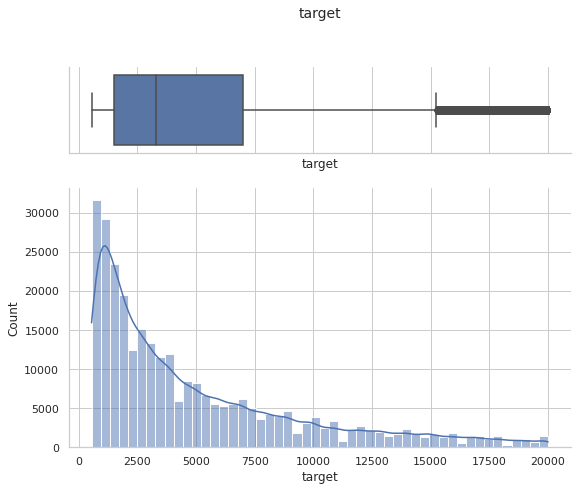


Feature statistics:


,target
count,289622.000000
mean,4951.763084
std,4518.359996
min,550.000000
25%,1500.000000
50%,3299.000000
75%,6990.000000
max,20000.000000


In [61]:
create_visualization(ds, 'target', 'target')

### Анализ количественных фичей

Visualization of quantitative features distribution:

Feature: q_registration_year


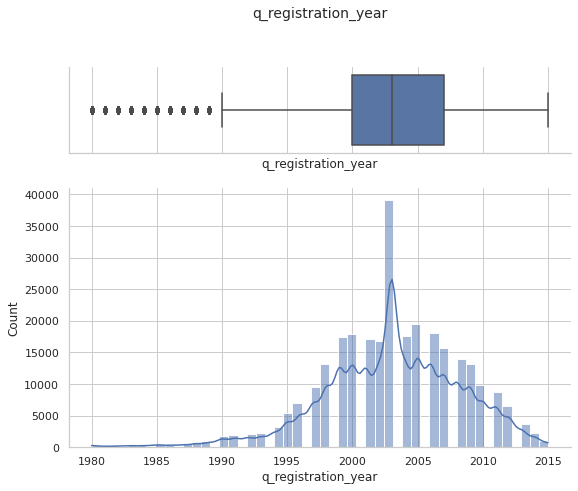


Feature statistics:


,q_registration_year
count,289622.0
mean,NaN
std,NaN
min,1980.0
25%,2000.0
50%,2003.0
75%,2007.0
max,2015.0


Feature: q_kilometer


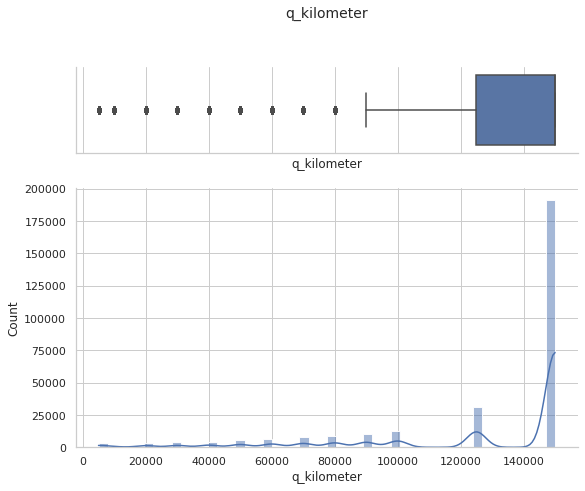


Feature statistics:


,q_kilometer
count,289622.00
mean,127861.51
std,37318.67
min,5000.00
25%,125000.00
50%,150000.00
75%,150000.00
max,150000.00


In [62]:
create_visualization(ds, 'numbers', 'target')

### Анализ категориальных фичей

Visualization of categorical features and target prevalence:

Feature: c_vehicle_type


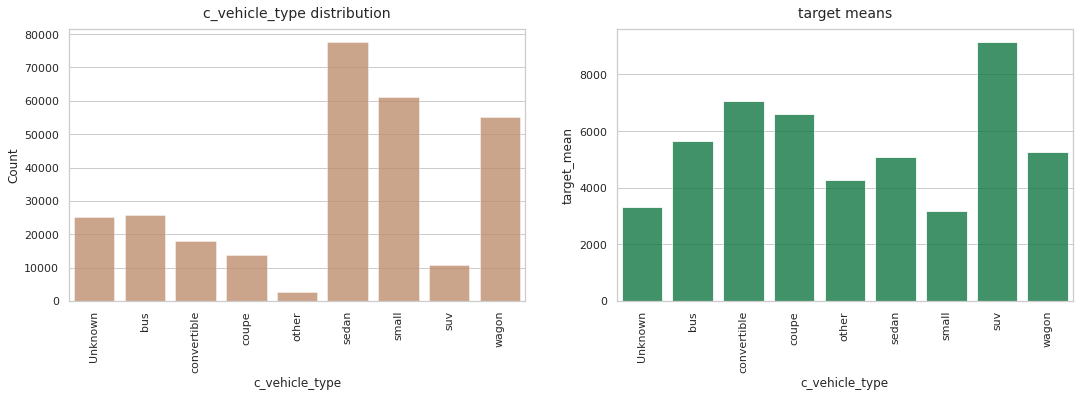


Feature: c_gearbox


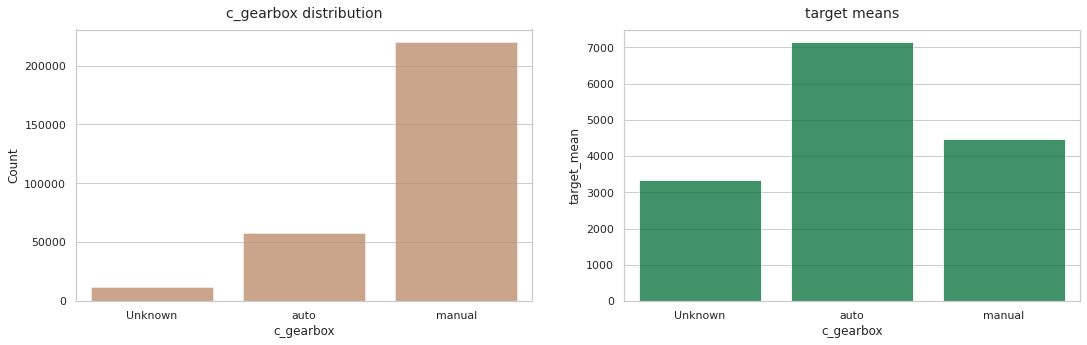


Feature: c_power


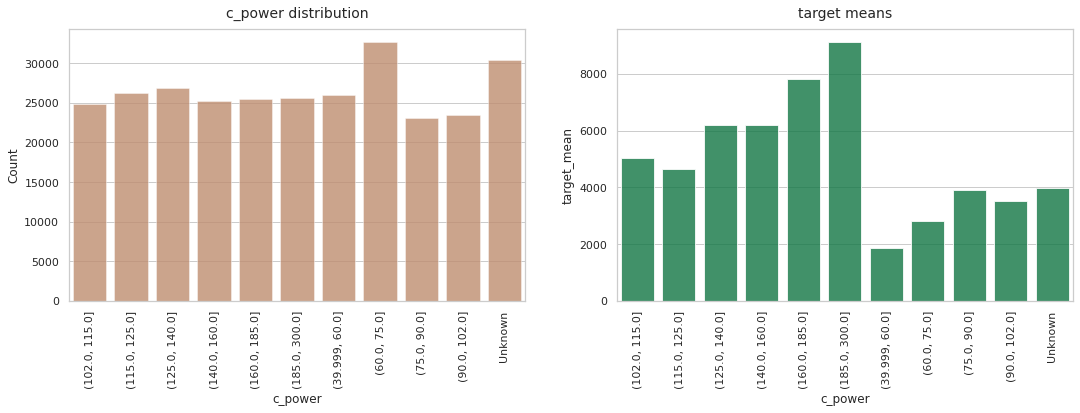


Feature: c_model


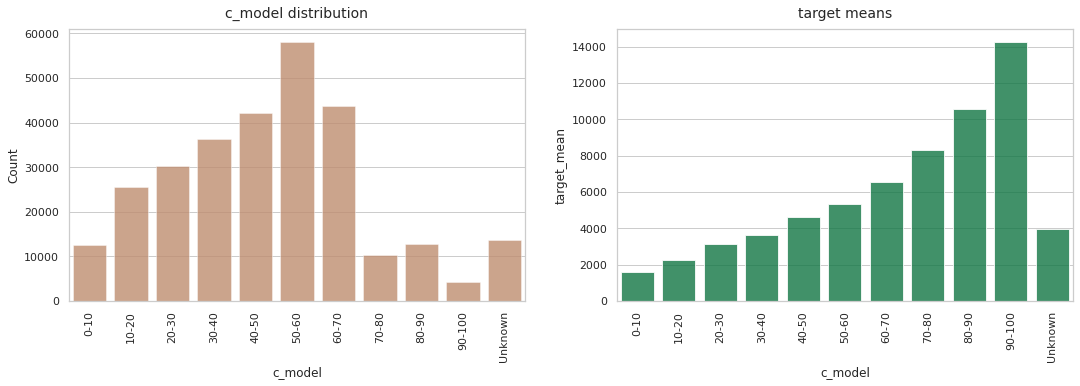


Feature: c_registration_month


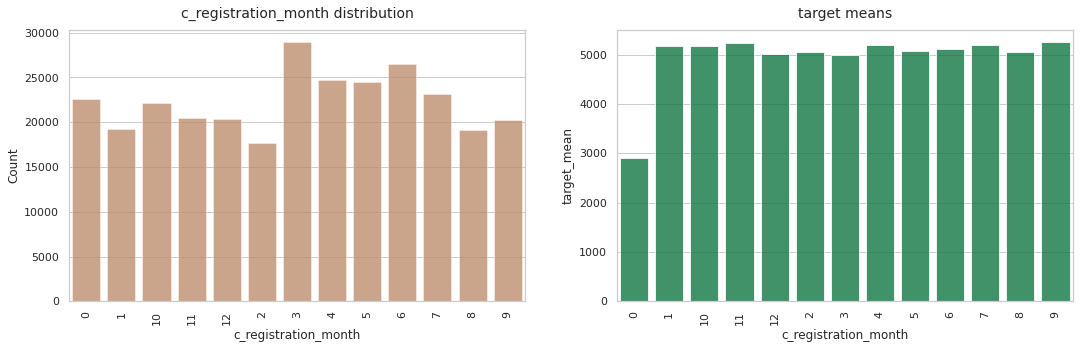


Feature: c_fuel


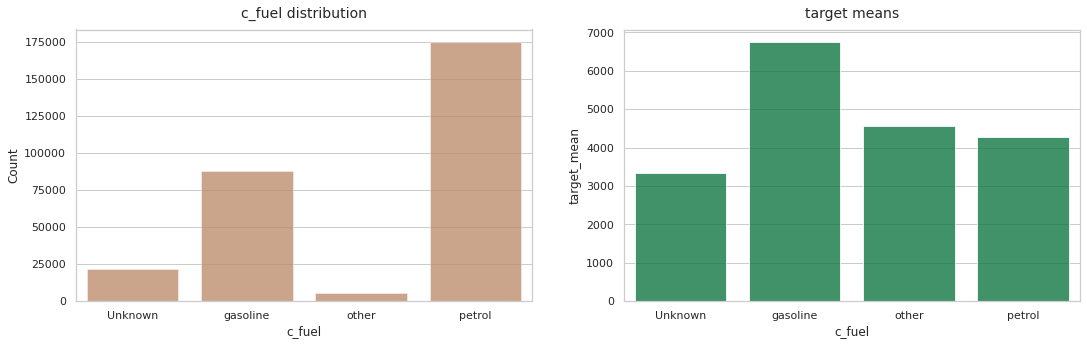


Feature: c_brand


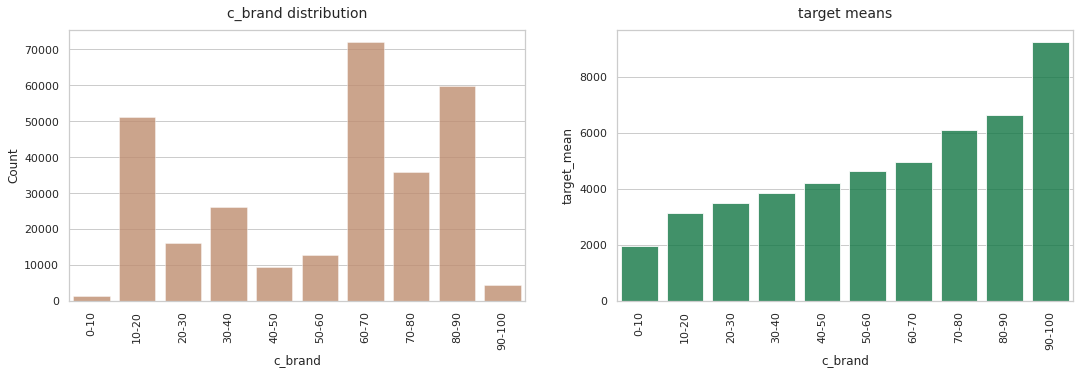


Feature: c_repaired


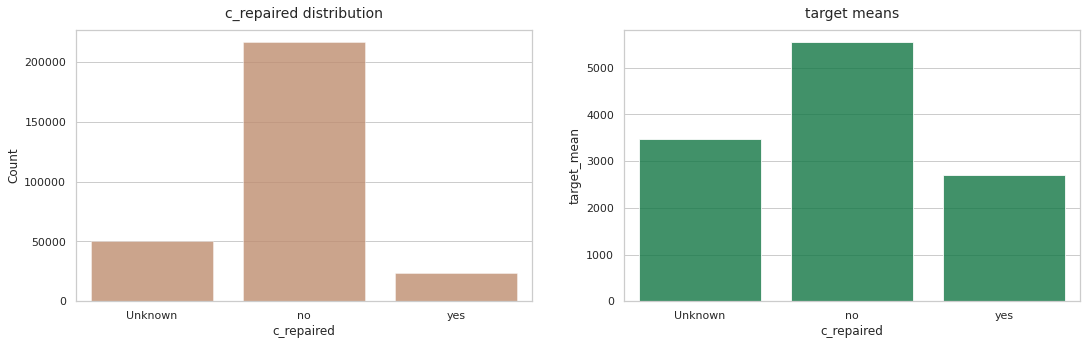


Feature: c_postal_code


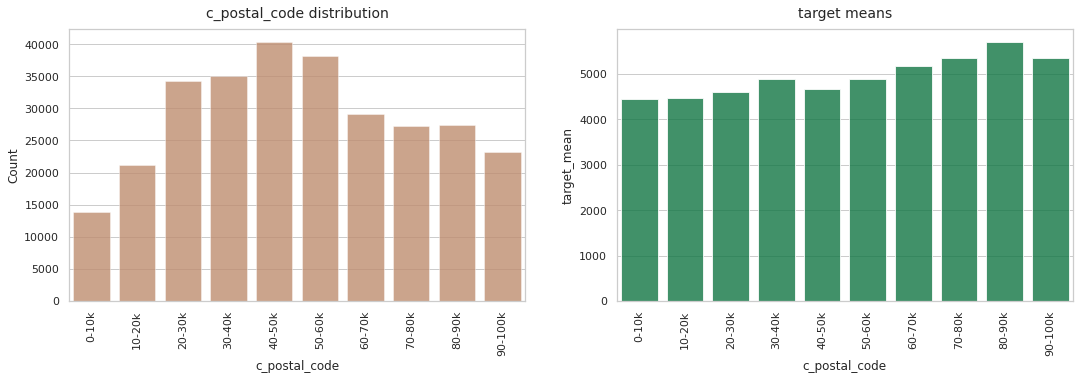

In [63]:
create_visualization(ds, 'categories', 'target')

### Корреляционный анализ датасета

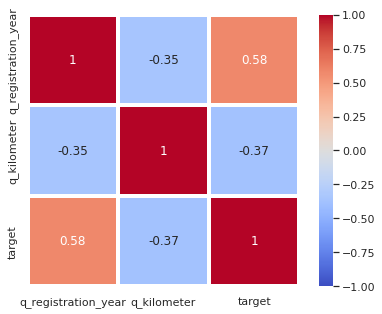

In [64]:
get_corr_map(ds, figisze=(7, 5))

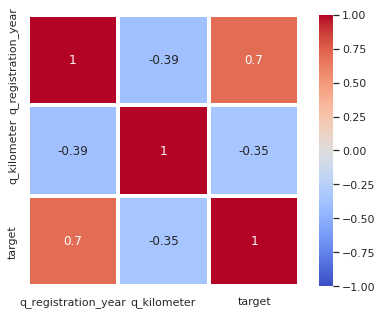

In [65]:
get_corr_map(ds, 'spearman', figisze=(7, 5))

# Формирование выборок и их препроцессинг

## Формирование выборок

In [66]:
X = ds.drop('target', axis=1)
y = ds['target']

In [67]:
X_, X_test, y_, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(
    X_, y_, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print('Sampling was successful!')
print('\n')
print('The shape of the training set for independent features:  ',
      X_train.shape)
print('The shape of the training set for target:                ',
      y_train.shape)
print()
print('The shape of the validation set for independent features:',
      X_val.shape)
print('The shape of the validation set for target:              ',
      y_val.shape)
print()
print('The shape of the test set for independent features:      ',
      X_test.shape)
print('The shape of the test set for target:                    ',
      y_test.shape)

Sampling was successful!


The shape of the training set for independent features:   (185357, 11)
The shape of the training set for target:                 (185357,)

The shape of the validation set for independent features: (46340, 11)
The shape of the validation set for target:               (46340,)

The shape of the test set for independent features:       (57925, 11)
The shape of the test set for target:                     (57925,)


## Препроцессинг выборок

Нормализуем количественные параметры с помощью метода `MinMax`, а категориальные параметры с помощью `OHE`.

### Нормализация колличественных фичей

In [68]:
scaler = SCALER.fit(X_train[q_features])

X_train[q_features] = scaler.transform(X_train[q_features])
X_val[q_features] = scaler.transform(X_val[q_features])
X_test[q_features] = scaler.transform(X_test[q_features])

print('Train sample:')
display(X_train.sample())
print()
print('Validation sample:')
display(X_val.sample())
print()
print('Test sample:')
display(X_val.sample())

Train sample:


,c_vehicle_type,c_gearbox,c_power,c_model,c_registration_month,c_fuel,c_brand,c_repaired,c_postal_code,q_registration_year,q_kilometer
142996,bus,manual,"(185.0, 300.0]",Unknown,6,petrol,10-20,Unknown,50-60k,0.657143,1.0



Validation sample:


,c_vehicle_type,c_gearbox,c_power,c_model,c_registration_month,c_fuel,c_brand,c_repaired,c_postal_code,q_registration_year,q_kilometer
115321,sedan,manual,"(185.0, 300.0]",40-50,8,petrol,30-40,yes,30-40k,0.6,1.0



Test sample:


,c_vehicle_type,c_gearbox,c_power,c_model,c_registration_month,c_fuel,c_brand,c_repaired,c_postal_code,q_registration_year,q_kilometer
121829,convertible,Unknown,"(75.0, 90.0]",30-40,5,petrol,20-30,no,30-40k,0.857143,0.310345


### OHE категориальных фичей

In [69]:
X_train_s = np.array([])
X_val_s = np.array([])

ohe = OHE.fit(X_train[cat_features])

X_train_ohe = ohe.transform(X_train[cat_features]).toarray()
X_val_ohe = ohe.transform(X_val[cat_features]).toarray()
X_test_ohe = ohe.transform(X_test[cat_features]).toarray()

X_train_ohe = np.concatenate([X_train_ohe, X_train[q_features]], 1)
X_val_ohe = np.concatenate([X_val_ohe, X_val[q_features]], 1)
X_test_ohe = np.concatenate([X_test_ohe, X_test[q_features]], 1)


print('Train shape:     ', X_train_ohe.shape)
print()
print('Validation shape:', X_val_ohe.shape)
print()
print('Validation shape:', X_test_ohe.shape)

Train shape:      (185357, 67)

Validation shape: (46340, 67)

Validation shape: (57925, 67)


### Ordinal Enconding категориальных фичей

In [70]:
X_train_s = np.array([])
X_val_s = np.array([])

oe = OE.fit(X_train[cat_features])

X_train_oe = oe.transform(X_train[cat_features])
X_val_oe = oe.transform(X_val[cat_features])
X_test_oe = oe.transform(X_test[cat_features])

X_train_oe = np.concatenate([X_train_oe, X_train[q_features]], 1)
X_val_oe = np.concatenate([X_val_oe, X_val[q_features]], 1)
X_test_oe = np.concatenate([X_test_oe, X_test[q_features]], 1)


print('Train shape:     ', X_train_oe.shape)
print()
print('Validation shape:', X_val_oe.shape)
print()
print('Validation shape:', X_test_oe.shape)

Train shape:      (185357, 11)

Validation shape: (46340, 11)

Validation shape: (57925, 11)


# Обучение моделей

Создадим и проверим следующие модели:
1. Простая линейная регрессия;
2. Случайный лес;
3. Многослойный перцептрон;
4. XGBoost;
5. LightGBM;
6. CatBoost.

Поскольку целью обучения данных моделей является определение наиболее подходящего под данные алгоримта, мы построем простые модели без поиска оптимальных параметров, взамен установив часть гиперпараметров вручную:
- Для случайного леса установим максимальную глубину дерева в 12, а количество деревьев - в 20;
- Для MLP - 300 итераций и скоростью обучения - 0.3;
- Для моделей на основе градиентного бустинга решающих деревьев установим 300 итераций и скоростью обучения - 0.3.


## Linear regresion

In [71]:
model_lr= LinearRegression()

lr_res, st_time_lr, pred_time_lr = get_prediction(
    X_train=X_train_ohe, y_train=y_train, X_val=X_val_ohe, y_val=y_val,
    model=model_lr, model_type='LR', print_res=True)

print('Study time:     ', st_time_lr)
print('Prediction time:', pred_time_lr)

Training RMSE score:    2563.48
Training R2 score:      0.48696744794275404

Validation RMSE score:  2582.76
Validation R2 score:    0.4810135500498841
Study time:      00:00:01
Prediction time: 00:00:00


## RF

In [72]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=10,
                                 n_estimators=100)

rf_res, st_time_rf, pred_time_rf = get_prediction(
    X_train=X_train_oe, y_train=y_train, X_val=X_val_oe, y_val=y_val, 
    model=model_rf, model_type='RF', print_res=True)

print('Study time:     ', st_time_rf)
print('Prediction time:', pred_time_rf)

Training RMSE score:    1962.89
Training R2 score:      0.7551062628054039

Validation RMSE score:  2064.39
Validation R2 score:    0.7291062382145417
Study time:      00:00:35
Prediction time: 00:00:00


## MLPRegressor

In [73]:
model_mlp = MLPRegressor(random_state=RANDOM_STATE, max_iter=300,
                         learning_rate_init=0.3, early_stopping=True)

mlp_res, st_time_mlp, pred_time_mlp = get_prediction(
    X_train=X_train_ohe, y_train=y_train, X_val=X_val_ohe, y_val=y_val,
    model=model_mlp, model_type='MLP', print_res=True)

print('Study time:     ', st_time_mlp)
print('Prediction time:', pred_time_mlp)

Training RMSE score:    1840.7
Training R2 score:      0.796102104131583

Validation RMSE score:  1913.2
Validation R2 score:    0.7807097666708767
Study time:      00:00:34
Prediction time: 00:00:00


## XGBoost

[15:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


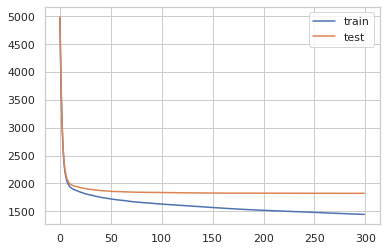

Training RMSE score:    1460.24
Training R2 score:      0.8797825302153685

Validation RMSE score:  1821.36
Validation R2 score:    0.8115654416000895
Study time:      00:01:15
Prediction time: 00:00:01


In [74]:
model_xgb = XGBRegressor(random_state=RANDOM_STATE, max_depth=7,
                         n_estimators=300, learning_rate=0.3)

xgb_res, st_time_xgb, pred_time_xgb = get_prediction(
    X_train=X_train_oe, y_train=y_train, X_val=X_val_oe, y_val=y_val,
    model=model_xgb, model_type='XGB', print_res=True)

print('Study time:     ', st_time_xgb)
print('Prediction time:', pred_time_xgb)

## LightGBM

Training RMSE score:    1660.0
Training R2 score:      0.8403026508163971

Validation RMSE score:  1832.3
Validation R2 score:    0.8064169023453931
Study time:      00:00:04
Prediction time: 00:00:01


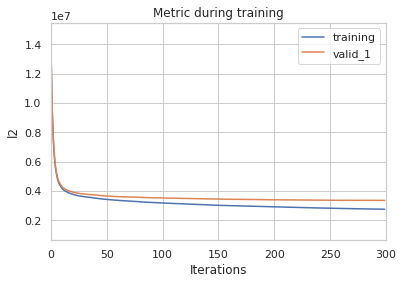

In [75]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE, max_depth=7,
                           n_estimators=300, learning_rate=0.3)

lgbm_res, st_time_lgbm, pred_time_lgbm = get_prediction(
    X_train=X_train_oe, y_train=y_train, X_val=X_val_oe, y_val=y_val,
    model=model_lgbm, model_type='LGBM', print_res=True)

print('Study time:     ', st_time_lgbm)
print('Prediction time:', pred_time_lgbm)

## CatBoost

In [76]:
model_cb = CatBoostRegressor(random_state=RANDOM_STATE, task_type='CPU',
                             cat_features=cat_features, learning_rate=0.3,
                             max_depth=7, iterations=300,
                             early_stopping_rounds=300)

cb_res, st_time_cb, pred_time_cb = get_prediction(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
    model=model_cb, model_type='CatBoost', print_res=True)

print('Study time:     ', st_time_cb)
print('Prediction time:', pred_time_cb)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training RMSE score:    1696.41
Training R2 score:      0.8329857715065552

Validation RMSE score:  1809.31
Validation R2 score:    0.8102164075516908
Study time:      00:01:23
Prediction time: 00:00:00


# Анализ качества и быстродействия моделей

Сгруппируем результаты в таблицу.

In [77]:
result = pd.DataFrame(
    {
        'Linear Regression': [lr_res['train_rmse'], lr_res['val_rmse'],
                              lr_res['train_r2'], lr_res['val_r2'],
                              st_time_lr, pred_time_lr],
        'Random Forest': [rf_res['train_rmse'], rf_res['val_rmse'],
                          rf_res['train_r2'], rf_res['val_r2'],
                          st_time_rf, pred_time_rf],
        'MLP': [mlp_res['train_rmse'], mlp_res['val_rmse'],
                mlp_res['train_r2'], mlp_res['val_r2'],
                st_time_mlp, pred_time_mlp],
        'XGBoost': [xgb_res['train_rmse'], xgb_res['val_rmse'],
                    xgb_res['train_r2'], xgb_res['val_r2'],
                   st_time_xgb, pred_time_xgb],
        'LightGBM': [lgbm_res['train_rmse'], lgbm_res['val_rmse'],
                     lgbm_res['train_r2'], lgbm_res['val_r2'],
                    st_time_lgbm, pred_time_lgbm],
        'CatBoost': [cb_res['train_rmse'], cb_res['val_rmse'],
                     cb_res['train_r2'], cb_res['val_r2'],
                    st_time_cb, pred_time_cb],
    }, index=[
        'Training RMSE score', 'Validation RMSE score', 'Training R2 score', 
        'Validation R2 score', 'Studying time', 'Prediction time']
)

result

,Linear Regression,Random Forest,MLP,XGBoost,LightGBM,CatBoost
Training RMSE score,2563.48,1962.89,1840.7,1460.24,1660.0,1696.41
Validation RMSE score,2582.76,2064.39,1913.2,1821.36,1832.3,1809.31
Training R2 score,0.486967,0.755106,0.796102,0.879783,0.840303,0.832986
Validation R2 score,0.481014,0.729106,0.78071,0.811565,0.806417,0.810216
Studying time,00:00:01,00:00:35,00:00:34,00:01:15,00:00:04,00:01:23
Prediction time,00:00:00,00:00:00,00:00:00,00:00:01,00:00:01,00:00:00


Можно сделать сделать следующие выводы:
- Результаты моделей по метрике `RMSE` на валидационной выборке в порядке возрастания (от лучшей модели к хуйдшей):
    1. Catboost (1809.31);
    2. XGBoost (1821.36);
    3. LightGBM (1832.3);
    4. MLP (1913.2);
    5. RF (2064.39);
    6. LR (2582.76).

Все модели, за исключением простой линейной регрессии смогли пройти порог в метрике `RMSE` в 2500. Линейной регрессии не хватило всего лишь 83 евро для прохождения порога, чего может быть возможно добиться с помощью увеличения обучающей выборки.

Стоит также отметить, что все модели, основанные на деревьях решений были переобучены, что обуславливает нобходимость дополнительной настройки лучшей модели.

- Результаты моделей по времени обучения в порядке возрастания (от лучшей модели к хуйдшей):
    1. LR (00:00:03);
    2. LightGBM (00:00:11);
    3. RF (00:00:28);
    4. CatBoost (00:01:52);
    5. XGBoost (00:03:32);
    6. MLP (00:09:51).
    
- Все модели осуществляют прогноз единичного наблюдения почти мгновенно.

Таки образом, можно определить LightGBM как лучшую модель на данном датасете: несмотря на то, что XGBoost незначительно вырвался вперед по метрике `RMSE`, время обучения у LightGBM меньше почти в 30 раз.

Проверим лучшую модель на тестовой выборке.



# Тестирование лучшей модели

In [78]:
zeros_correction = np.vectorize(lambda x: 0 if x < 0 else x)
preds_correction = np.vectorize(lambda x: round(abs(x)))

test_preds = preds_correction(zeros_correction(model_lgbm.predict(X_test_oe)))

res = pd.DataFrame(
    {
        'RMSE': round(mean_squared_error(test_preds, y_test) ** 0.5, 2),
        'R2':   r2_score(test_preds, y_test),
    }, index=['Best model result']
).T

res

Results:


,Optimized LGBM
RMSE,1814.660000
R2,0.808944


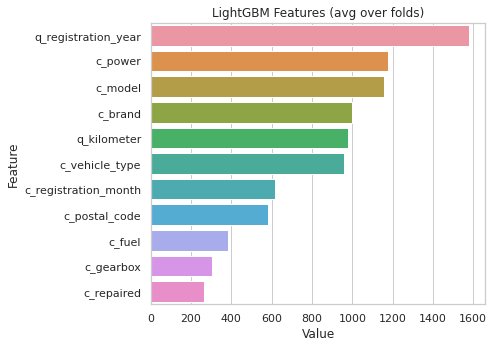

In [79]:
feature_imp = pd.DataFrame(
    sorted(zip(model_lgbm.feature_importances_, X.columns)),
    columns=['Value','Feature'])

plt.figure(figsize=(7, 5))
sns.barplot(x="Value", y="Feature",
            data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# Выводы

Для достижения цели **разработать модели машинного обучения, способные предсказывать стоимость автоомобиля, и отобрать из них лучшую на основе метрик качества и скорости обучения**, была проделана следующая работа:

1. Был проведен исследовательский анализ данных и их предобработка, и были сделаны следующие выводы:
    - В данных присутствуют выбросы, а их распределения ненормальные;
    - В данных присутствует множество аномалий, а именно:
        - Присутствие объявлений о продаже автомобилей за крайне низкие цены, в том числе и за бесплатно (нулевые значения цены);
        - Год регистрации автомобиля имеет сильный разброс: от 1000-ого года до 6000-ого года;
        - Мощность двигателя также имеет ошибки в данных: некоторые автомобили имееют мощность в 0 л.с. или 20000 л.с.;
        - Киллометраж имеет категориальную, а не количественную форму в данных;
        - Количество фотографий представлено единственным значением (0);
        - Год регистрации автомобилей содержит ещё не наступившие года;
    - Были выделены признаки, которые стоит включить в датасет, а также оценено влияние признаков на целевой параметр.
2. С учетом выводом, полученных из исследовательского анализа данных, была проведена предобработка данных, в частности:
    - Удалены из данных аномально низкие значения целевого параметра;
    - Заменены средним годом регистрации аномальные значения года регистрации;
    - Заменены пропусками аномальные значения мозщности двигателя с последующей трансформацией параметра в категориальный признак;
    - Модели и бренды были сгруппированы по ценовым категориям;
    - Редкие категории параметра тип топлива были сгруппированы в одну группу;
    - Почтовые коды были также укрупнены в более общие группы;
3. Был сформирован датасет, а также обучающая и валидационная выборки:
    - Из датасета были удалены все дубликаты;
    - Обучающая и валидационная выборки были сформирвоны в соотношении 75% к 25% соответственно;
    - Количественные фичи были нормализованы с помощью метода MinMax;
    - Категориальные фичи были разбиты на бинарные признаки с помощью OHE;
4. Были разработаны и проанализированны следующие ML-модели:
    1. Linear Regression;
    2. Random Forrest;
    3. MLP;
    4. XGBoost;
    5. LightGBM;
    6. CatBoost.

5. Наиболее подходящей под цель работы была определена модель LightGBM со следующими характеристиками:
    - RMSE - 1832 евро;
    - Скорость обучения - 11 секунд.

6. Наиболее важными параметрами, влияющими на стоимость автомобиля являются:
    1. Год регистрации автомобиля;
    2. Мощность двигателя;
    3. Бренд автомобиля;
    4. Километраж автомобиля;
    5. Тип коробки передач.


7. При тестировании отобранная модель достигает следующих результатов по метрике RMSE в 1814.66 евро

Для последующей работы необходимо определить природу аномалий и исправить ошибки в данных после чего стоит настроить гиперпараметры предложенной модели для повышения её качества.

Таким образом, можно сказать, что цель данной работы достигнута.

![](https://media.tenor.com/woog9FdsHDYAAAAC/duck-dance.gif)